# ML-ImmuneProfiler

## Single-Cell RNA-seq Cell Type Classification: Notebook 3

## Linear Classifier Models 01 (Linear Ridge Classifier, Logistic Regression (L1, L2))

- Date: 2025-04-17

This notebook implements and compares linear models for single-cell RNA-sequencing classification:

1. **Ridge Classifier**: A linear classifier using L2 regularization
2. **Logistic Regression with L1 (Lasso)**: Creates sparse models by forcing some coefficients to zero
3. **Logistic Regression with L2 (Ridge)**: Shrinks coefficients proportionally without eliminating features

The notebook evaluates these models on PBMC (Peripheral Blood Mononuclear Cell) data across multiple cell types, including B cells, T cells, monocytes, and other immune cells. Each model is evaluated on validation data with detailed performance metrics such as accuracy, F1-scores, confusion matrices, ROC curves, and precision-recall curves. UMAP visualizations are used to show how predictions correspond to the underlying data structure. Feature importance analysis identifies the most discriminative genes for cell type classification.



In [33]:
# ------ Module Import ------ #

# Default imports
import os
import time
import pickle
import joblib
from tqdm import tqdm

# External Imports (General imports)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# External Imports (ML imports)
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import umap.umap_ as umap

# Warning suppression
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
warnings.filterwarnings("ignore", message="n_jobs value .* overridden to .* by setting random_state.*")


In [3]:
# Global Variables
RAND_SEED: int = 16         # it's my birthday :)

DATA_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Data')
RESULTS_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Results')
PLOT_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Plots')
MODEL_DIR: str = os.path.join(os.path.dirname(os.getcwd()), 'Models')
# Create directories if they do not exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
# load the dataset
spv_dataset = joblib.load(os.path.join(DATA_DIR, 'spv_split_dataset_100hvg.pkl'))

# verify the integrity of cell types in test, train and validation sets
def verify_cell_types_integrity(spv_dataset):
    """
    Verify the integrity of cell types in the train, validation, and test sets.
    """
    print("Verifying cell types integrity...")
    
    # Check unique classes in each split
    for split in ['train', 'val', 'test']:
        y_split = spv_dataset[f'y_{split}']
        unique_classes = np.unique(y_split)
        print(f"Unique classes in {split} set: {unique_classes}")
    
    # Check for common classes across all splits
    train_classes = set(np.unique(spv_dataset['y_train']))
    val_classes = set(np.unique(spv_dataset['y_val']))
    test_classes = set(np.unique(spv_dataset['y_test']))
    
    common_classes = train_classes.intersection(val_classes, test_classes)
    print(f"Common classes across all splits: {sorted(list(common_classes))}")
    
    # Check class distributions
    label_encoder = spv_dataset['label_encoder']
    class_names = label_encoder.classes_
    
    print("\nClass distribution ratios (% of total):")
    print(f"{'Class':<15} {'Train %':<10} {'Val %':<10} {'Test %':<10} {'Total %':<10}")
    print("-" * 55)
    
    total_train = len(spv_dataset['y_train'])
    total_val = len(spv_dataset['y_val'])
    total_test = len(spv_dataset['y_test'])
    total_all = total_train + total_val + total_test
    
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        total_count = train_count + val_count + test_count
        
        train_ratio = train_count / total_train * 100
        val_ratio = val_count / total_val * 100
        test_ratio = test_count / total_test * 100
        total_ratio = total_count / total_all * 100
        
        print(f"{class_name:<15} {train_ratio:>8.2f}% {val_ratio:>8.2f}% {test_ratio:>8.2f}% {total_ratio:>8.2f}%")
    
    # Check dataset split ratios
    print("\nDataset split ratios:")
    print(f"Train: {total_train / total_all * 100:.2f}% ({total_train} samples)")
    print(f"Val:   {total_val / total_all * 100:.2f}% ({total_val} samples)")
    print(f"Test:  {total_test / total_all * 100:.2f}% ({total_test} samples)")
    
    # Check for potential cross-validation issues
    print("\nPotential CV issues assessment:")
    
    # Check if any classes are missing from any split
    if len(train_classes) != len(class_names) or len(val_classes) != len(class_names) or len(test_classes) != len(class_names):
        print("Warning: Some classes are missing from one or more splits!")
        print(f"Missing from train: {sorted(list(set(range(len(class_names))) - train_classes))}")
        print(f"Missing from val: {sorted(list(set(range(len(class_names))) - val_classes))}")
        print(f"Missing from test: {sorted(list(set(range(len(class_names))) - test_classes))}")
    else:
        print("✓ All classes are represented in each split")
    
    # Check for severe class imbalance
    class_balance_issues = []
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        
        if train_count < 5 or val_count < 5 or test_count < 5:
            class_balance_issues.append(f"{class_name} (train={train_count}, val={val_count}, test={test_count})")
    
    if class_balance_issues:
        print("Warning: Some classes have very few samples in some splits:")
        for issue in class_balance_issues:
            print(f"  - {issue}")
    else:
        print("✓ All classes have sufficient samples in each split")
    
    # Check split ratios per class
    print("\nSplit ratios per class:")
    print(f"{'Class':<15} {'Train %':<10} {'Val %':<10} {'Test %':<10}")
    print("-" * 45)
    
    for i, class_name in enumerate(class_names):
        train_count = np.sum(spv_dataset['y_train'] == i)
        val_count = np.sum(spv_dataset['y_val'] == i)
        test_count = np.sum(spv_dataset['y_test'] == i)
        class_total = train_count + val_count + test_count
        
        class_train_ratio = train_count / class_total * 100
        class_val_ratio = val_count / class_total * 100
        class_test_ratio = test_count / class_total * 100
        
        print(f"{class_name:<15} {class_train_ratio:>8.2f}% {class_val_ratio:>8.2f}% {class_test_ratio:>8.2f}%")
    
    print("\nIntegrity verification complete!")

verify_cell_types_integrity(spv_dataset)

Verifying cell types integrity...
Unique classes in train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique classes in val set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique classes in test set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Common classes across all splits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Class distribution ratios (% of total):
Class           Train %    Val %      Test %     Total %   
-------------------------------------------------------
B intermediate      4.53%     4.53%     4.53%     4.53%
B memory            2.85%     2.85%     2.85%     2.85%
B naive             9.96%     9.95%     9.95%     9.96%
CD14 Mono          12.58%    12.57%    12.58%    12.58%
CD16 Mono           8.26%     8.26%     8.26%     8.26%
CD4 Naive           9.25%     9.25%     9.25%     9.25%
CD4 TCM            12.03%    12.03%    12.03%    12.03%
CD4 TEM             1.74%     1.73%     1.73%     1.74%
CD8 Naive          11.80%    11.80%    11.80%    11.80%
CD8 TCM 

In [5]:
# Dataset extract components
X_train = spv_dataset['X_train']
X_val = spv_dataset['X_val']
X_test = spv_dataset['X_test']
y_train = spv_dataset['y_train']
y_val = spv_dataset['y_val']
y_test = spv_dataset['y_test']
meta_train = spv_dataset['meta_train']
meta_val = spv_dataset['meta_val']
meta_test = spv_dataset['meta_test']
label_encoder = spv_dataset['label_encoder']
class_weights = spv_dataset['class_weights']
feature_genes = spv_dataset['feature_genes']

# Display dataset shapes with more formatting
print("Dataset Shapes:")
print(f"X_train: {X_train.shape} samples x {X_train.shape[1]} features")
print(f"X_val:   {X_val.shape} samples x {X_val.shape[1]} features")
print(f"X_test:  {X_test.shape} samples x {X_test.shape[1]} features")
print(f"y_train: {y_train.shape}")
print(f"y_val:   {y_val.shape}")
print(f"y_test:  {y_test.shape}")

# Display class information 
print("\nClass Names and Encodings:")
classes = label_encoder.classes_
for i, class_name in enumerate(classes):
    count_train = np.sum(y_train == i)
    count_val = np.sum(y_val == i)
    count_test = np.sum(y_test == i)
    total_count = count_train + count_val + count_test
    weight = class_weights.get(i, "N/A")
    print(f"Class {i:<2} = {class_name:<15} | Train: {count_train:<5} | Val: {count_val:<5} | Test: {count_test:<5} | Total: {total_count:<5} | Weight: {weight}")

# Display feature gene statistics
print(f"\nFeature Genes: {len(feature_genes)} genes")
print(f"First 10 genes: {feature_genes[:10]}")
print(f"Last 10 genes: {feature_genes[-10:]}")

# Check for NaN values
print("\nData Quality Check:")
nan_train = np.isnan(X_train).sum()
nan_val = np.isnan(X_val).sum()
nan_test = np.isnan(X_test).sum()

if np.any(nan_train):
    print(f"Warning: Found {nan_train} NaN values in X_train")
    print(f"NaN distribution per feature: {np.isnan(X_train).sum(axis=0)[np.isnan(X_train).sum(axis=0) > 0]}")
else:
    print("✓ X_train: No NaN values detected")
    
if np.any(nan_val):
    print(f"Warning: Found {nan_val} NaN values in X_val")
    print(f"NaN distribution per feature: {np.isnan(X_val).sum(axis=0)[np.isnan(X_val).sum(axis=0) > 0]}")
else:
    print("✓ X_val: No NaN values detected")
    
if np.any(nan_test):
    print(f"Warning: Found {nan_test} NaN values in X_test")
    print(f"NaN distribution per feature: {np.isnan(X_test).sum(axis=0)[np.isnan(X_test).sum(axis=0) > 0]}")
else:
    print("✓ X_test: No NaN values detected")

# Check data types
print(f"\nData Types:")
print(f"X_train dtype: {X_train.dtypes.unique()}")
print(f"y_train dtype: {y_train.dtype}")

Dataset Shapes:
X_train: (53825, 100) samples x 100 features
X_val:   (11534, 100) samples x 100 features
X_test:  (11534, 100) samples x 100 features
y_train: (53825,)
y_val:   (11534,)
y_test:  (11534,)

Class Names and Encodings:
Class 0  = B intermediate  | Train: 2438  | Val: 523   | Test: 522   | Total: 3483  | Weight: 1.5769658971053557
Class 1  = B memory        | Train: 1535  | Val: 329   | Test: 329   | Total: 2193  | Weight: 2.504653327128897
Class 2  = B naive         | Train: 5360  | Val: 1148  | Test: 1148  | Total: 7656  | Weight: 0.7172841151385928
Class 3  = CD14 Mono       | Train: 6769  | Val: 1450  | Test: 1451  | Total: 9670  | Weight: 0.567977966781335
Class 4  = CD16 Mono       | Train: 4445  | Val: 953   | Test: 953   | Total: 6351  | Weight: 0.8649365257914189
Class 5  = CD4 Naive       | Train: 4980  | Val: 1067  | Test: 1067  | Total: 7114  | Weight: 0.7720166379804934
Class 6  = CD4 TCM         | Train: 6475  | Val: 1387  | Test: 1388  | Total: 9250  | Weigh

### Linear Ridge Classifier Model (Sklearn)

#### Building and Training Ridge Classifier using Scikit-learn pipeline

In [7]:
# Create Ridge Classifier with scaling
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeClassifier(
        alpha=1.0,  # Regularization strength
        class_weight=class_weights,
        random_state=16
    ))
])

print("Training Ridge classifier...")
ridge_pipeline.fit(X_train, y_train)

# Get predictions on validation set
y_val_pred_ridge = ridge_pipeline.predict(X_val)

# Use a calibrated classifier to get probability estimates (Ridge doesn't output probabilities by default)
calibrated_ridge = CalibratedClassifierCV(
    ridge_pipeline, 
    method='sigmoid', 
    cv='prefit'
)
calibrated_ridge.fit(X_val, y_val)  # Fit on validation data
y_val_proba_ridge = calibrated_ridge.predict_proba(X_val)

print("\nRidge Classifier - Classification Report")
print(classification_report(y_val, y_val_pred_ridge, target_names=label_encoder.classes_))

Training Ridge classifier...

Ridge Classifier - Classification Report
                 precision    recall  f1-score   support

 B intermediate       0.60      0.51      0.55       523
       B memory       0.56      0.60      0.58       329
        B naive       0.83      0.85      0.84      1148
      CD14 Mono       0.97      0.96      0.96      1450
      CD16 Mono       0.94      0.98      0.96       953
      CD4 Naive       0.60      0.76      0.67      1067
        CD4 TCM       0.93      0.37      0.53      1387
        CD4 TEM       0.35      0.69      0.46       200
      CD8 Naive       0.75      0.85      0.80      1361
        CD8 TCM       0.54      0.61      0.58       360
        CD8 TEM       0.94      0.81      0.87      1296
Dendritic cells       0.96      0.96      0.96       394
             NK       0.95      0.98      0.96       913
           Treg       0.29      0.86      0.44       153

       accuracy                           0.78     11534
      macro avg

##### Performance Metrics

In [8]:
# Calculate overall accuracy
accuracy = accuracy_score(y_val, y_val_pred_ridge)
weighted_f1 = f1_score(y_val, y_val_pred_ridge, average='weighted')
macro_f1 = f1_score(y_val, y_val_pred_ridge, average='macro')

print(f"\nRidge Classifier Performance:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

# Per-class performance
class_report = classification_report(y_val, y_val_pred_ridge, 
                                    target_names=label_encoder.classes_,
                                    output_dict=True)
class_metrics = pd.DataFrame(class_report).T
class_metrics = class_metrics.sort_values(by='f1-score', ascending=False)
print("\nTop 5 best-classified cell types:")
print(class_metrics.head(5)[['precision', 'recall', 'f1-score', 'support']])

print("\nBottom 5 worst-classified cell types:")
print(class_metrics.iloc[:-3].tail(5)[['precision', 'recall', 'f1-score', 'support']])


Ridge Classifier Performance:
Overall Accuracy: 0.7845
Weighted F1-Score: 0.7840
Macro F1-Score: 0.7257

Top 5 best-classified cell types:
                 precision    recall  f1-score  support
NK                0.951064  0.979189  0.964922    913.0
CD14 Mono         0.967247  0.957241  0.962218   1450.0
Dendritic cells   0.957071  0.961929  0.959494    394.0
CD16 Mono         0.943205  0.975866  0.959257    953.0
CD8 TEM           0.939231  0.810957  0.870393   1296.0

Bottom 5 worst-classified cell types:
                precision    recall  f1-score  support
macro avg        0.729563  0.770517  0.725704  11534.0
CD4 Naive        0.601783  0.759138  0.671363   1067.0
B memory         0.563218  0.595745  0.579025    329.0
CD8 TCM          0.543210  0.611111  0.575163    360.0
B intermediate   0.596882  0.512428  0.551440    523.0


#### Confusion Matrix

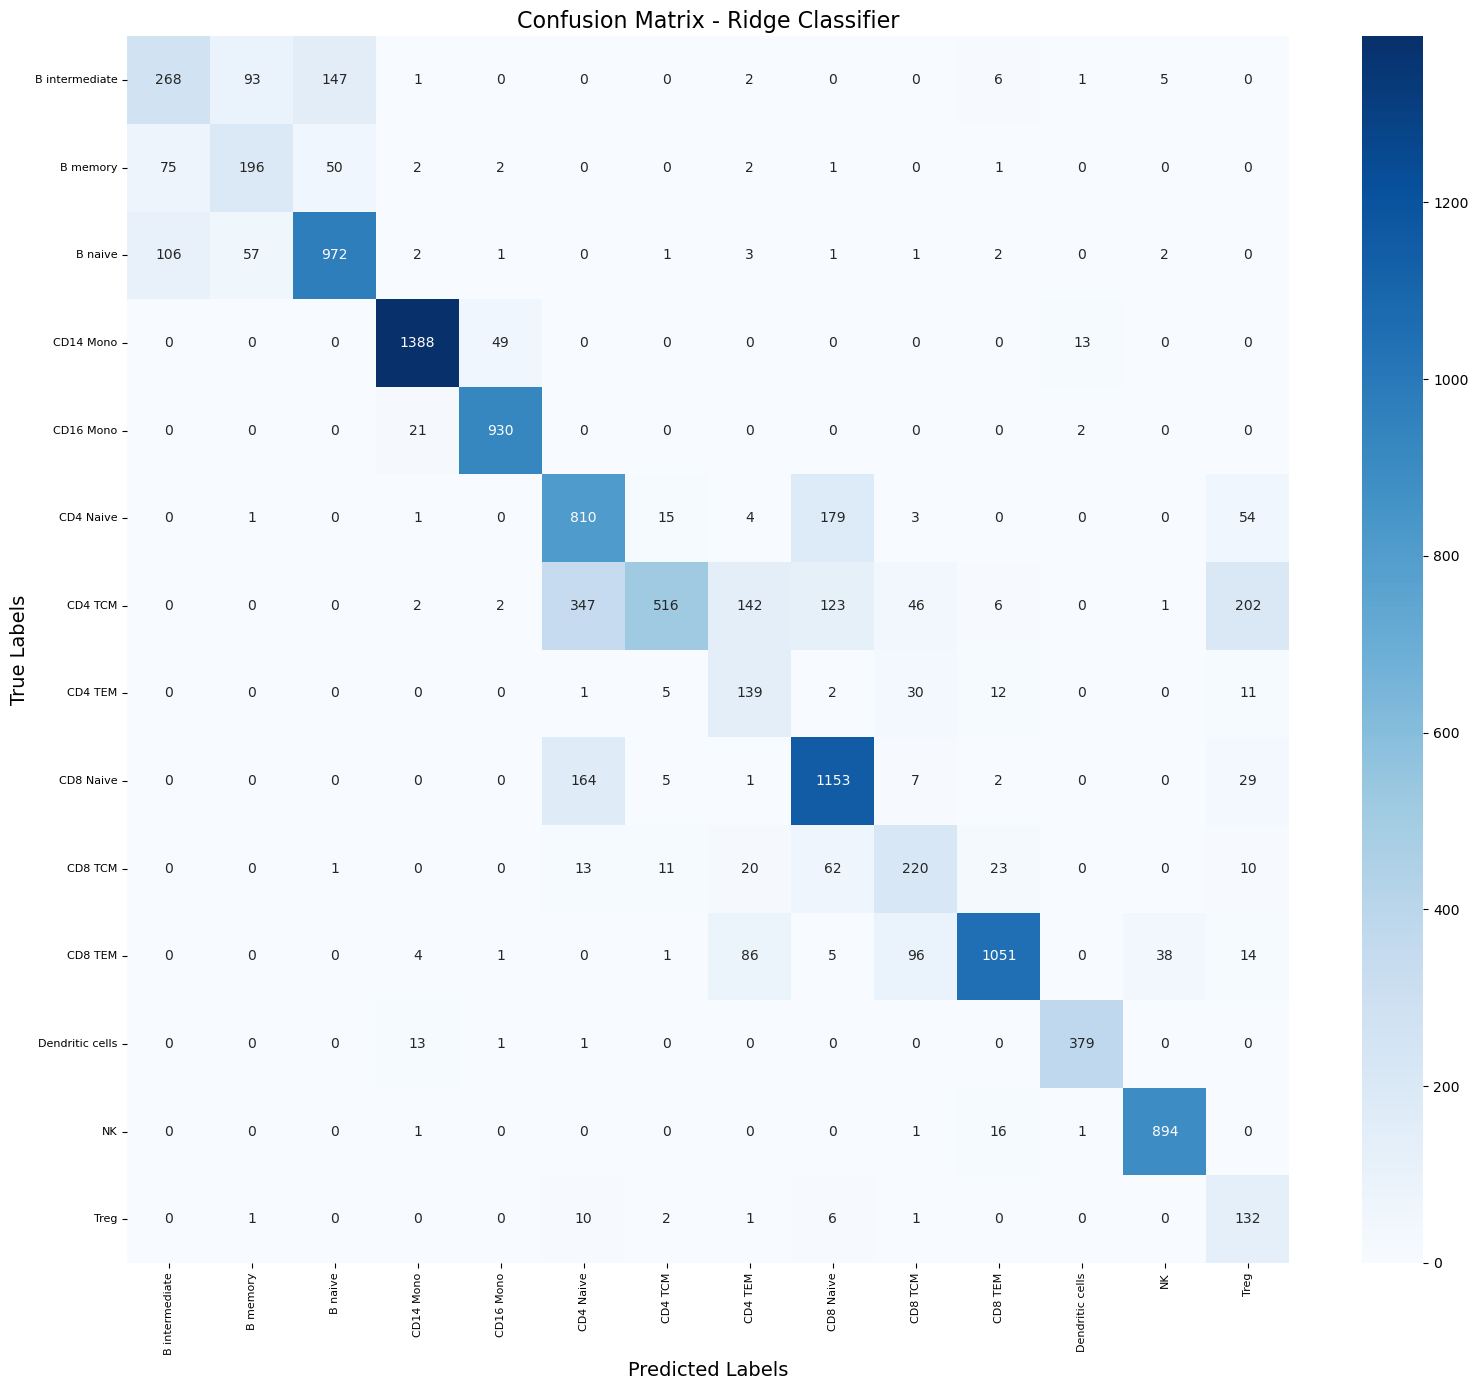

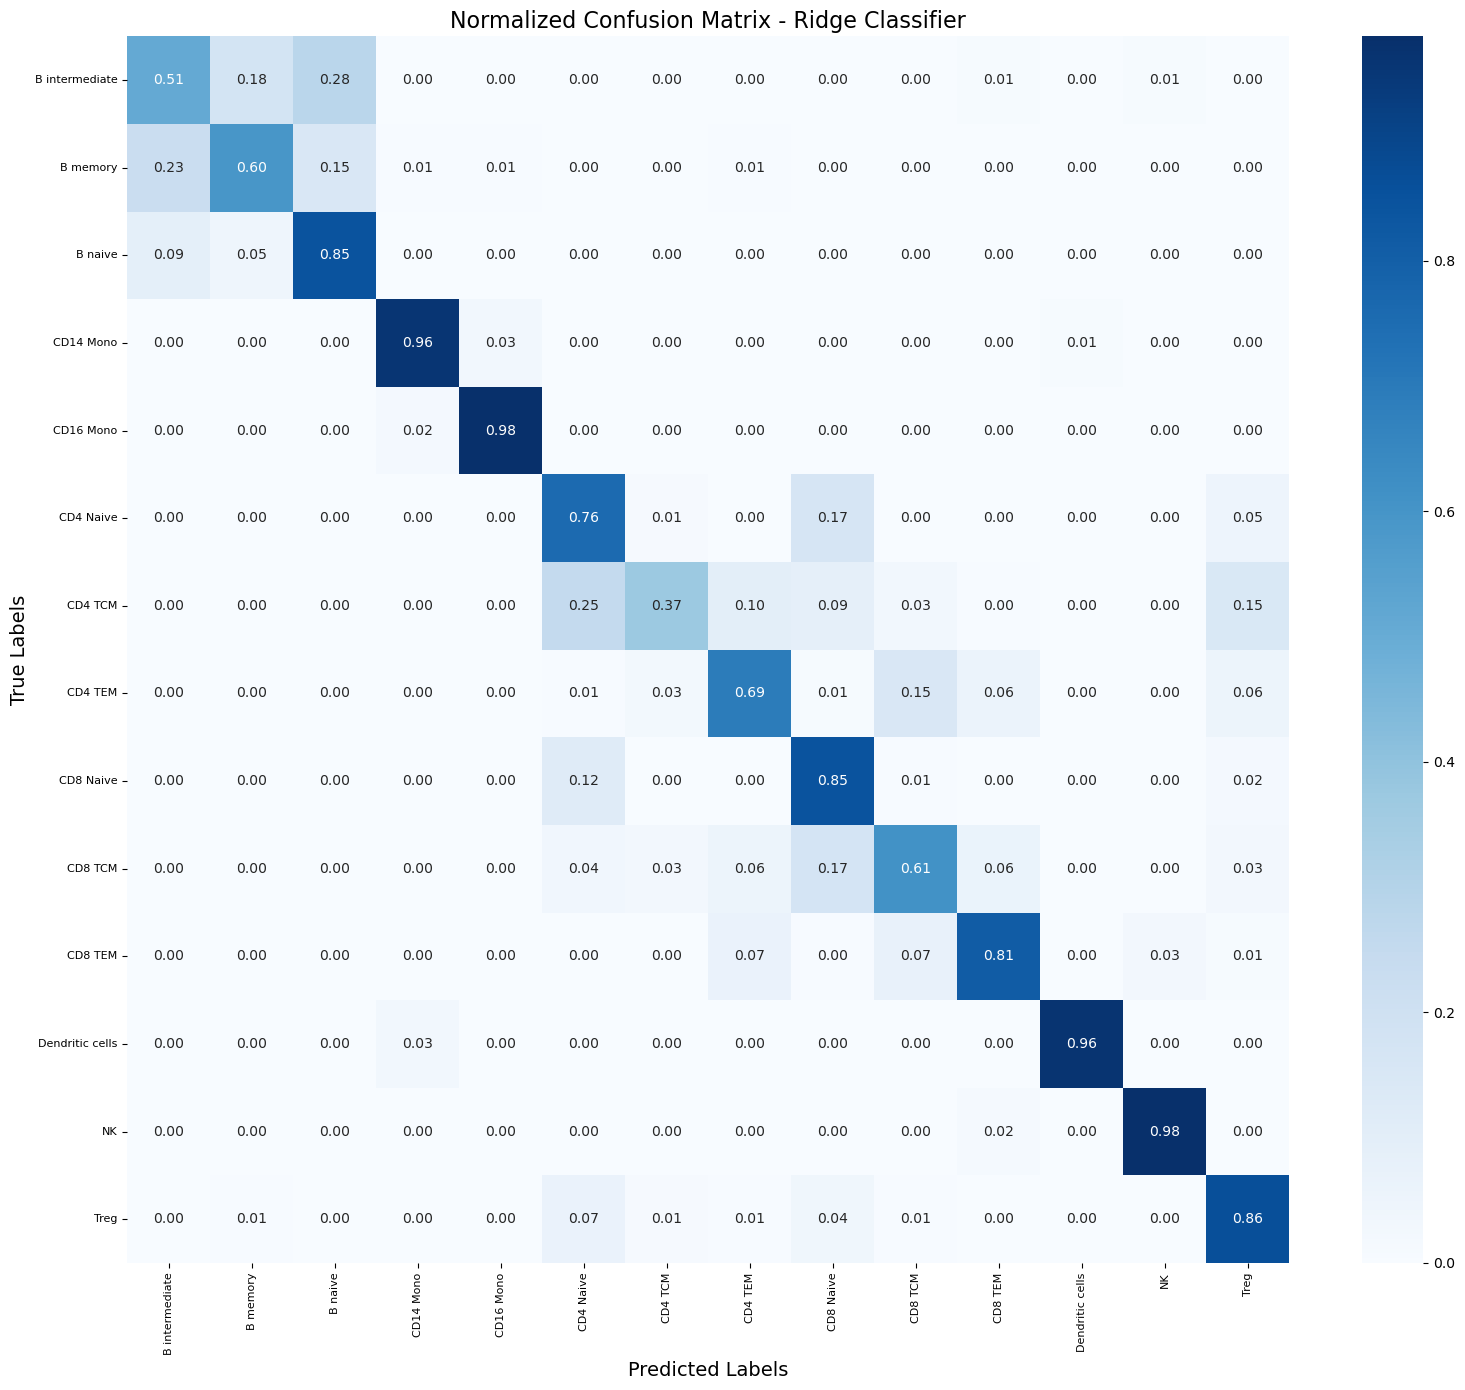

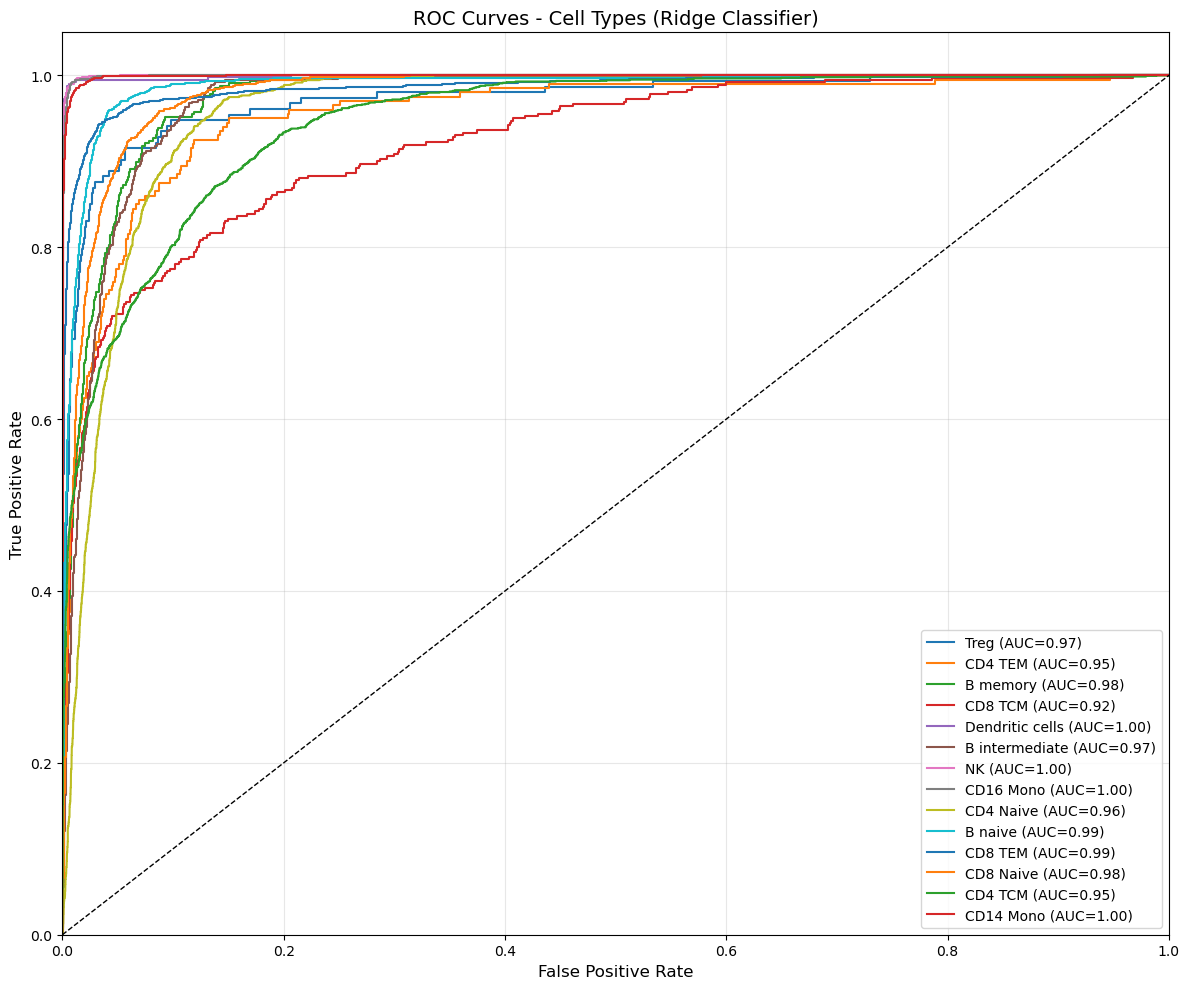

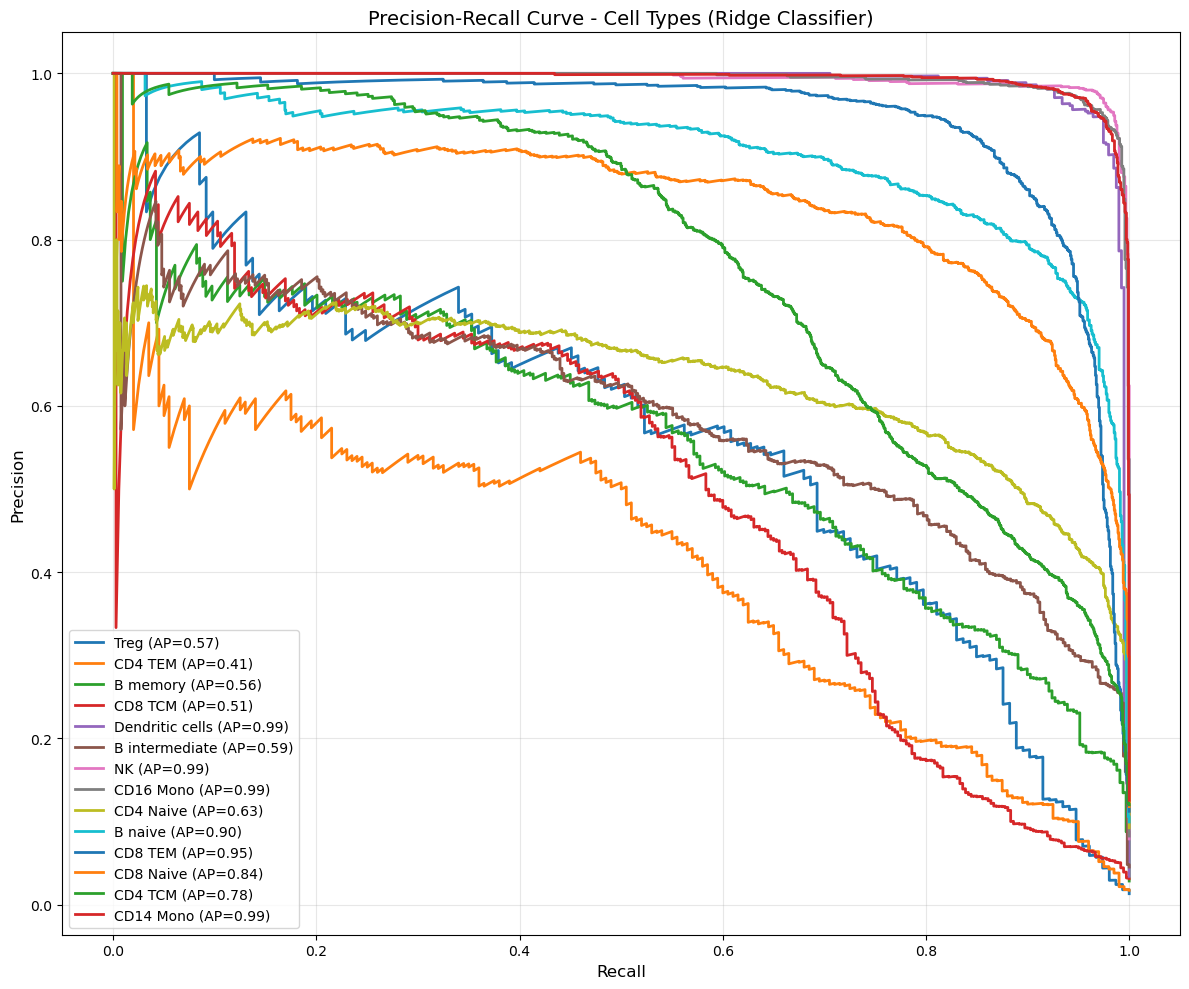

In [9]:
# Confusion Matrix for Ridge
plt.figure(figsize=(16, 14))
cm = confusion_matrix(y_val, y_val_pred_ridge)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Ridge Classifier", fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'confusion_matrix_ridge.png'), dpi=300, bbox_inches='tight')
plt.show()

# Normalized Confusion Matrix (by row) to show error distribution
plt.figure(figsize=(16, 14))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Normalized Confusion Matrix - Ridge Classifier", fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'normalized_confusion_matrix_ridge.png'), dpi=300, bbox_inches='tight')
plt.show()

# Binarize the validation labels
y_val_bin = label_binarize(y_val, classes=np.unique(y_train))
n_classes = y_val_bin.shape[1]

# ROC Curve - show for top 10 largest classes by support
class_supports = np.bincount(y_val)
all_classes = np.argsort(class_supports)[-14:]

plt.figure(figsize=(12, 10))
for i in all_classes:
    if i < n_classes:  # Ensure class index is valid
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba_ridge[:, i])
        roc_auc = auc(fpr, tpr)
        class_name = label_encoder.classes_[i]
        if len(class_name) > 15:
            class_name = class_name[:12] + '...'
        plt.plot(fpr, tpr, label=f'{class_name} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Cell Types (Ridge Classifier)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'roc_curve_ridge.png'), dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve for top 5 cell types
plt.figure(figsize=(12, 10))
for i in all_classes[:14]:  # Use smaller value for top classes if needed
    if i < n_classes:
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_val_proba_ridge[:, i])
        ap_score = average_precision_score(y_val_bin[:, i], y_val_proba_ridge[:, i])
        class_name = label_encoder.classes_[i]
        if len(class_name) > 15:
            class_name = class_name[:12] + '...'
        plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={ap_score:.2f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Cell Types (Ridge Classifier)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'pr_curve_ridge.png'), dpi=300, bbox_inches='tight')
plt.show()

##### UMAP Visualization Comparing True vs. Predicted Classes

Generating UMAP embedding for visualization...


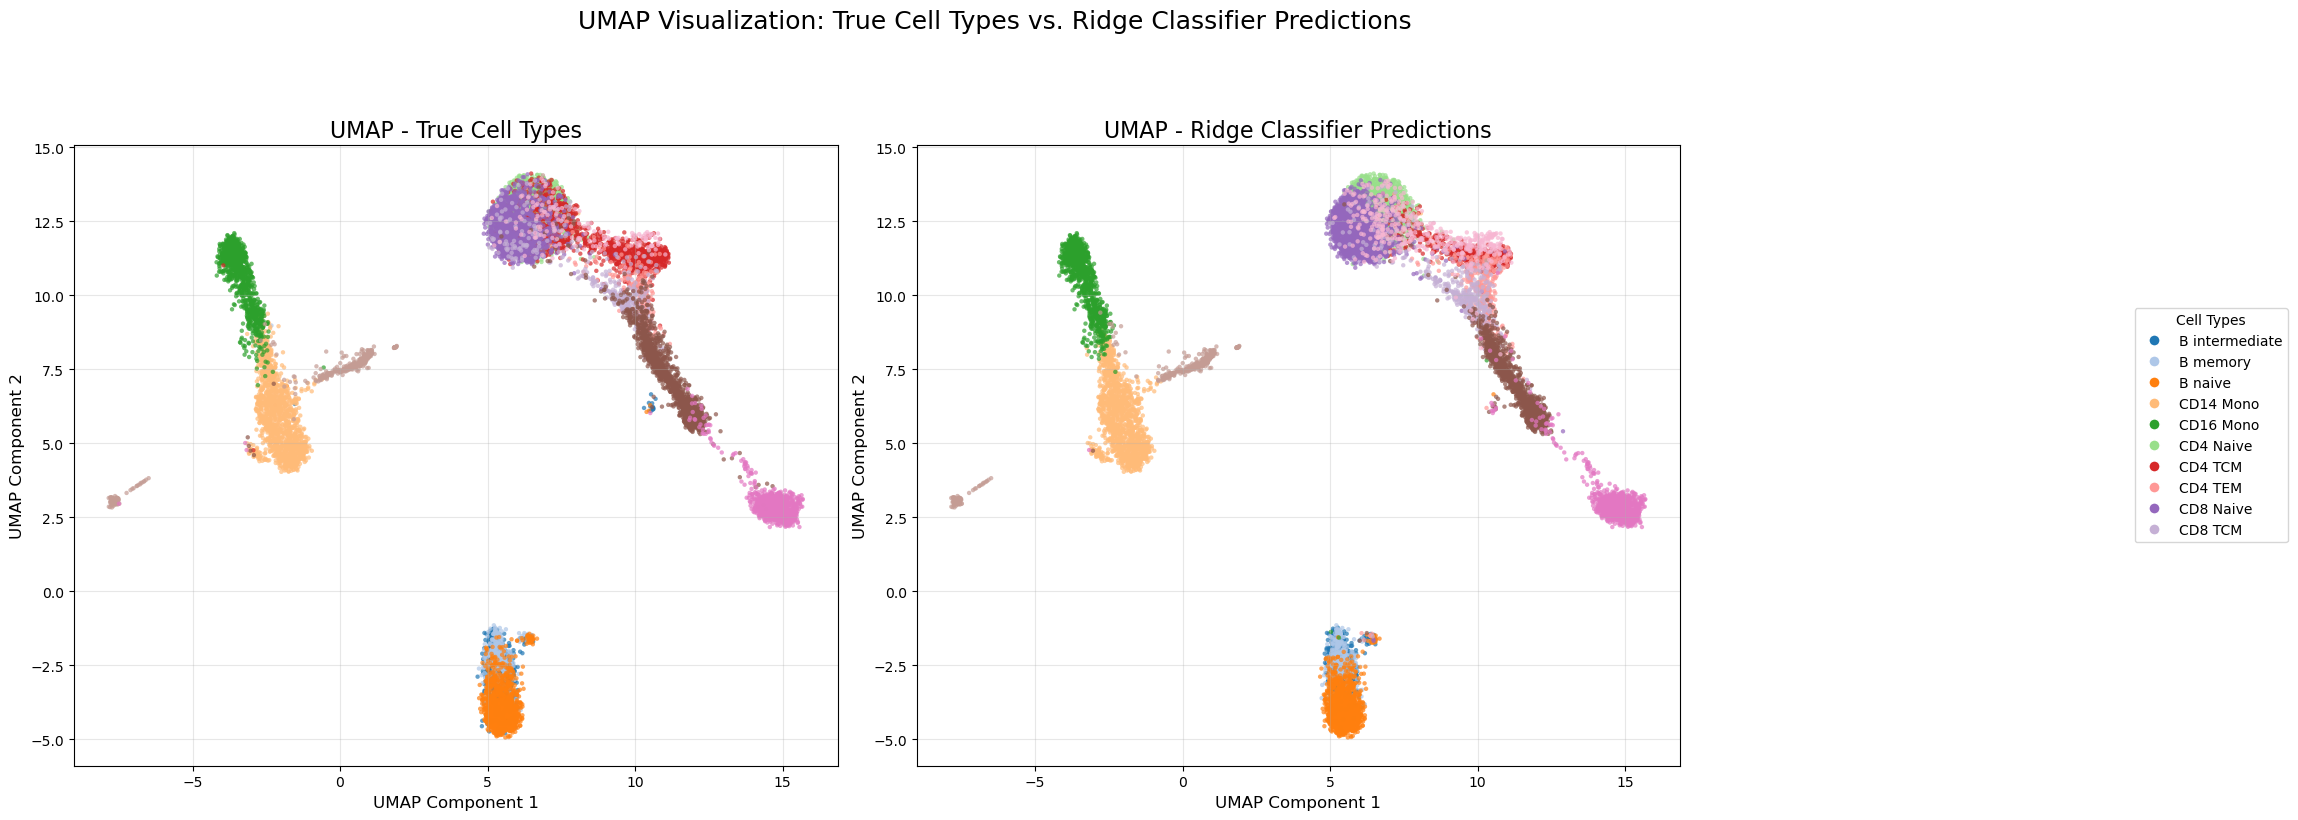

In [10]:
# Generate UMAP embedding for visualization
print("Generating UMAP embedding for visualization...")
reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=16)
X_val_umap = reducer.fit_transform(X_val)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Create color palette that maps cell types consistently
unique_cell_types = np.unique(meta_val['CellType'])
n_colors = len(unique_cell_types)
color_palette = sns.color_palette("tab20", n_colors=min(20, n_colors))
color_palette += sns.color_palette("tab20b", n_colors=max(0, n_colors-20))
color_dict = {cell_type: color_palette[i % len(color_palette)] 
                for i, cell_type in enumerate(unique_cell_types)}

# Plot 1: True Cell Types (Ground Truth)
for cell_type in unique_cell_types:
    mask = (meta_val['CellType'] == cell_type)
    ax1.scatter(
        X_val_umap[mask, 0], 
        X_val_umap[mask, 1],
        s=10, 
        color=color_dict[cell_type], 
        label=cell_type,
        alpha=0.7,
        edgecolor='none'
    )
ax1.set_title("UMAP - True Cell Types", fontsize=16)
ax1.set_xlabel("UMAP Component 1", fontsize=12)
ax1.set_ylabel("UMAP Component 2", fontsize=12)
ax1.grid(alpha=0.3)

# Plot 2: Ridge Classifier Predictions
predicted_cell_types = label_encoder.inverse_transform(y_val_pred_ridge)
for cell_type in unique_cell_types:
    mask = (predicted_cell_types == cell_type)
    ax2.scatter(
        X_val_umap[mask, 0], 
        X_val_umap[mask, 1],
        s=10, 
        color=color_dict[cell_type], 
        label=cell_type,
        alpha=0.7,
        edgecolor='none'
    )
ax2.set_title("UMAP - Ridge Classifier Predictions", fontsize=16)
ax2.set_xlabel("UMAP Component 1", fontsize=12)
ax2.set_ylabel("UMAP Component 2", fontsize=12)
ax2.grid(alpha=0.3)

# Create a legend for the first few cell types (to avoid overcrowding)
top_cell_types = sorted([(meta_val['CellType'] == ct).sum() for ct in unique_cell_types], reverse=True)
legend_size = min(10, len(unique_cell_types))
handles, labels = [], []
for i, cell_type in enumerate(unique_cell_types):
    if i < legend_size:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color_dict[cell_type], markersize=8))
        labels.append(cell_type)

# Add a figure legend for all cell types outside the plots
fig.legend(handles, labels, loc='center right', title="Cell Types", 
        bbox_to_anchor=(1.15, 0.5), ncol=1, fontsize=10)

# Add overall title and adjust layout
plt.suptitle("UMAP Visualization: True Cell Types vs. Ridge Classifier Predictions", fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig(os.path.join(PLOT_DIR, 'umap_ridge_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

##### Misclassification Analysis

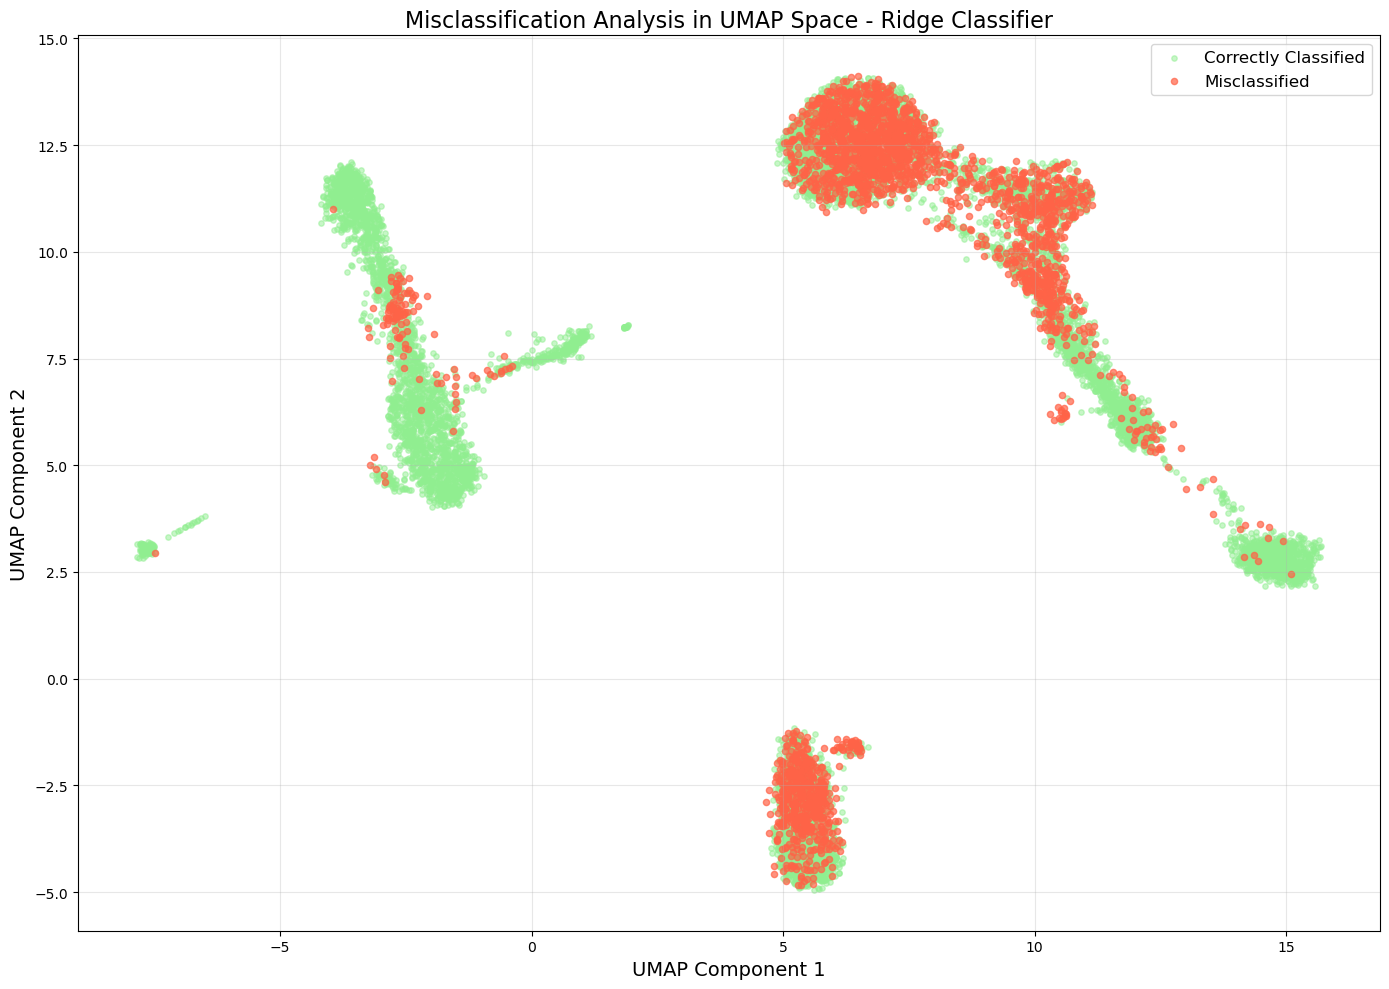

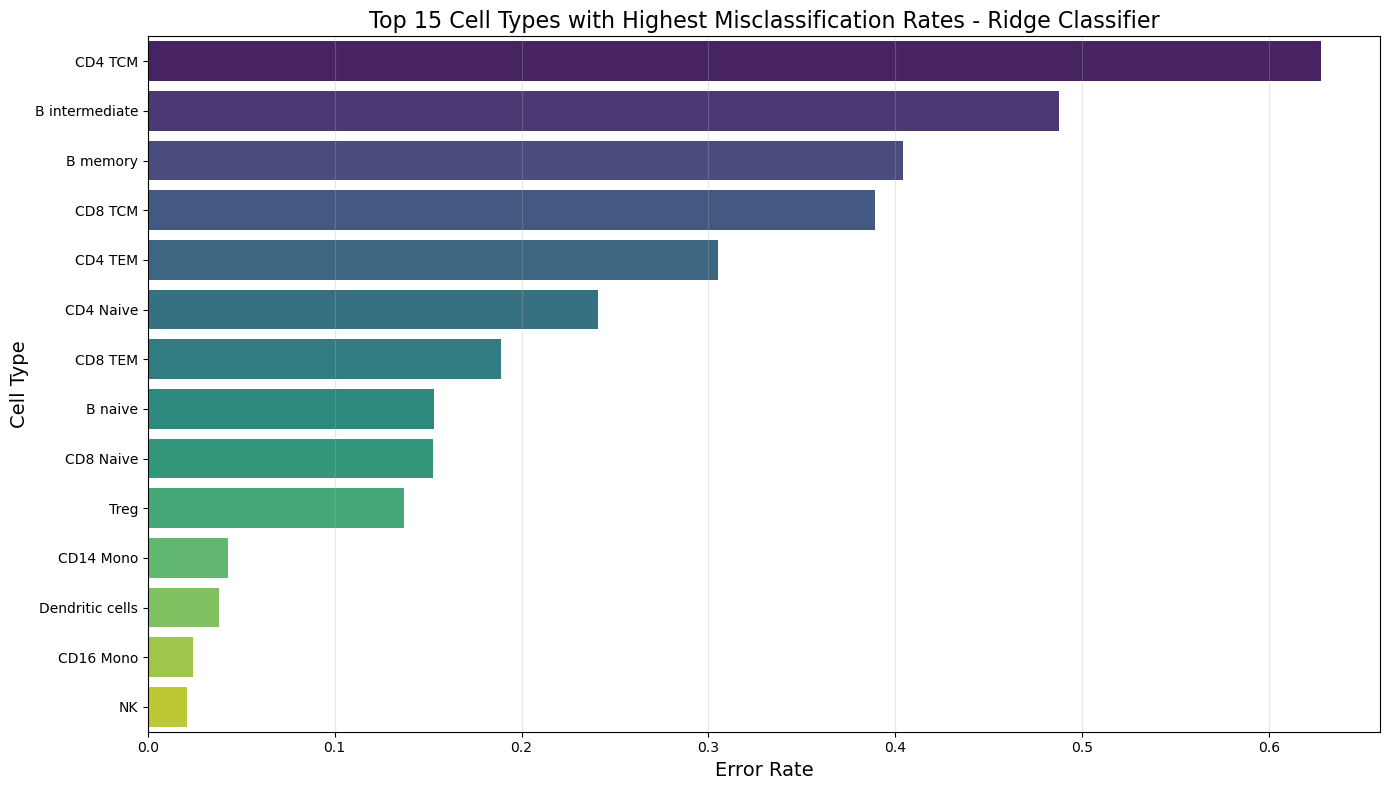


Most common misclassification pairs (True -> Predicted):
    True_Cell_Type Predicted_Cell_Type  Count
37         CD4 TCM           CD4 Naive    347
43         CD4 TCM                Treg    202
32       CD4 Naive           CD8 Naive    179
50       CD8 Naive           CD4 Naive    164
1   B intermediate             B naive    147
38         CD4 TCM             CD4 TEM    142
39         CD4 TCM           CD8 Naive    123
14         B naive      B intermediate    106
68         CD8 TEM             CD8 TCM     96
0   B intermediate            B memory     93


In [11]:
# Create a DataFrame for misclassification analysis
misclass_df = pd.DataFrame({
    'True_Cell_Type': label_encoder.inverse_transform(y_val),
    'Predicted_Cell_Type': label_encoder.inverse_transform(y_val_pred_ridge),
    'UMAP_1': X_val_umap[:, 0],
    'UMAP_2': X_val_umap[:, 1]
})
misclass_df['Correctly_Classified'] = misclass_df['True_Cell_Type'] == misclass_df['Predicted_Cell_Type']

# Plot misclassifications in UMAP space
plt.figure(figsize=(14, 10))
plt.scatter(
    misclass_df[misclass_df['Correctly_Classified']]['UMAP_1'],
    misclass_df[misclass_df['Correctly_Classified']]['UMAP_2'],
    c='lightgreen', s=15, alpha=0.5, label='Correctly Classified'
)
plt.scatter(
    misclass_df[~misclass_df['Correctly_Classified']]['UMAP_1'],
    misclass_df[~misclass_df['Correctly_Classified']]['UMAP_2'],
    c='tomato', s=20, alpha=0.7, label='Misclassified'
)
plt.title("Misclassification Analysis in UMAP Space - Ridge Classifier", fontsize=16)
plt.xlabel("UMAP Component 1", fontsize=14)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'ridge_misclassification_umap.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate misclassification rates by cell type
misclass_rates = misclass_df.groupby('True_Cell_Type')['Correctly_Classified'].agg(
    ['count', lambda x: (~x).sum(), lambda x: (~x).sum()/len(x)]
).reset_index()
misclass_rates.columns = ['Cell_Type', 'Total_Cells', 'Misclassified_Cells', 'Error_Rate']
misclass_rates = misclass_rates.sort_values('Error_Rate', ascending=False)

# Plot top 15 cell types with highest misclassification rates
plt.figure(figsize=(14, 8))
sns.barplot(
    data=misclass_rates.head(15),
    y='Cell_Type',
    x='Error_Rate',
    palette='viridis',
    hue="Cell_Type",
)
plt.title("Top 15 Cell Types with Highest Misclassification Rates - Ridge Classifier", fontsize=16)
plt.xlabel("Error Rate", fontsize=14)
plt.ylabel("Cell Type", fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'ridge_top_misclassified_types.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print the most common misclassification pairs
print("\nMost common misclassification pairs (True -> Predicted):")
misclass_pairs = misclass_df[~misclass_df['Correctly_Classified']].groupby(
    ['True_Cell_Type', 'Predicted_Cell_Type']
).size().reset_index().rename(columns={0: 'Count'})
misclass_pairs = misclass_pairs.sort_values('Count', ascending=False)
print(misclass_pairs.head(10))

##### Feature Importance Analysis

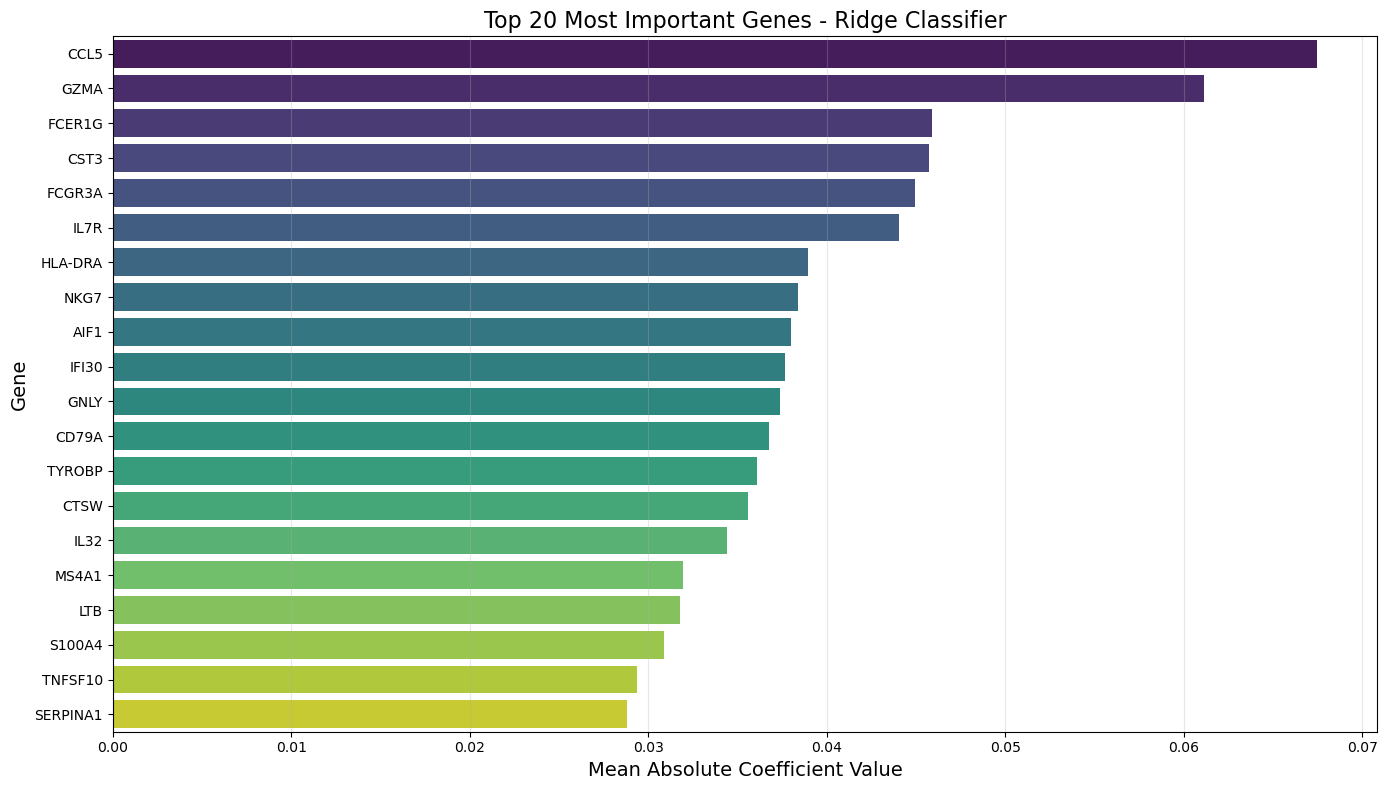

In [12]:
# Extract coefficients from the Ridge classifier
ridge_classifier = ridge_pipeline.named_steps['ridge']
feature_importances = np.abs(ridge_classifier.coef_).mean(axis=0)

# Create DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_genes,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Plot top 20 most important genes
plt.figure(figsize=(14, 8))
sns.barplot(
    data=feature_importance_df.head(20),
    y='Feature',
    x='Importance',
    palette='viridis',
    hue="Feature"
)
plt.title("Top 20 Most Important Genes - Ridge Classifier", fontsize=16)
plt.xlabel("Mean Absolute Coefficient Value", fontsize=14)
plt.ylabel("Gene", fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'ridge_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

##### Confidence Distribution Analysis

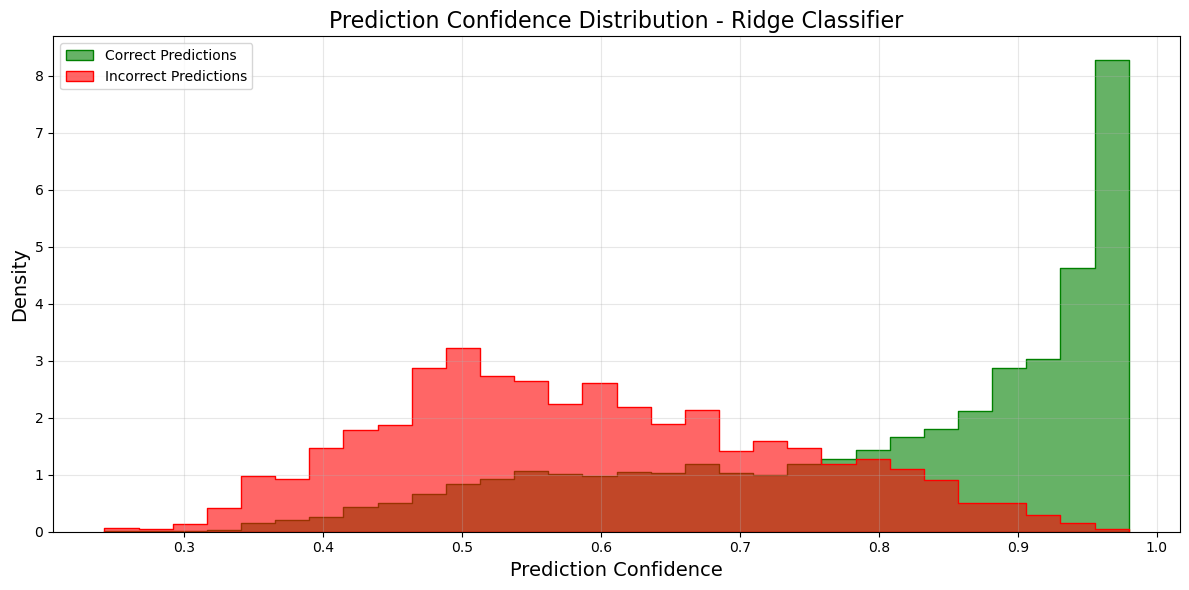

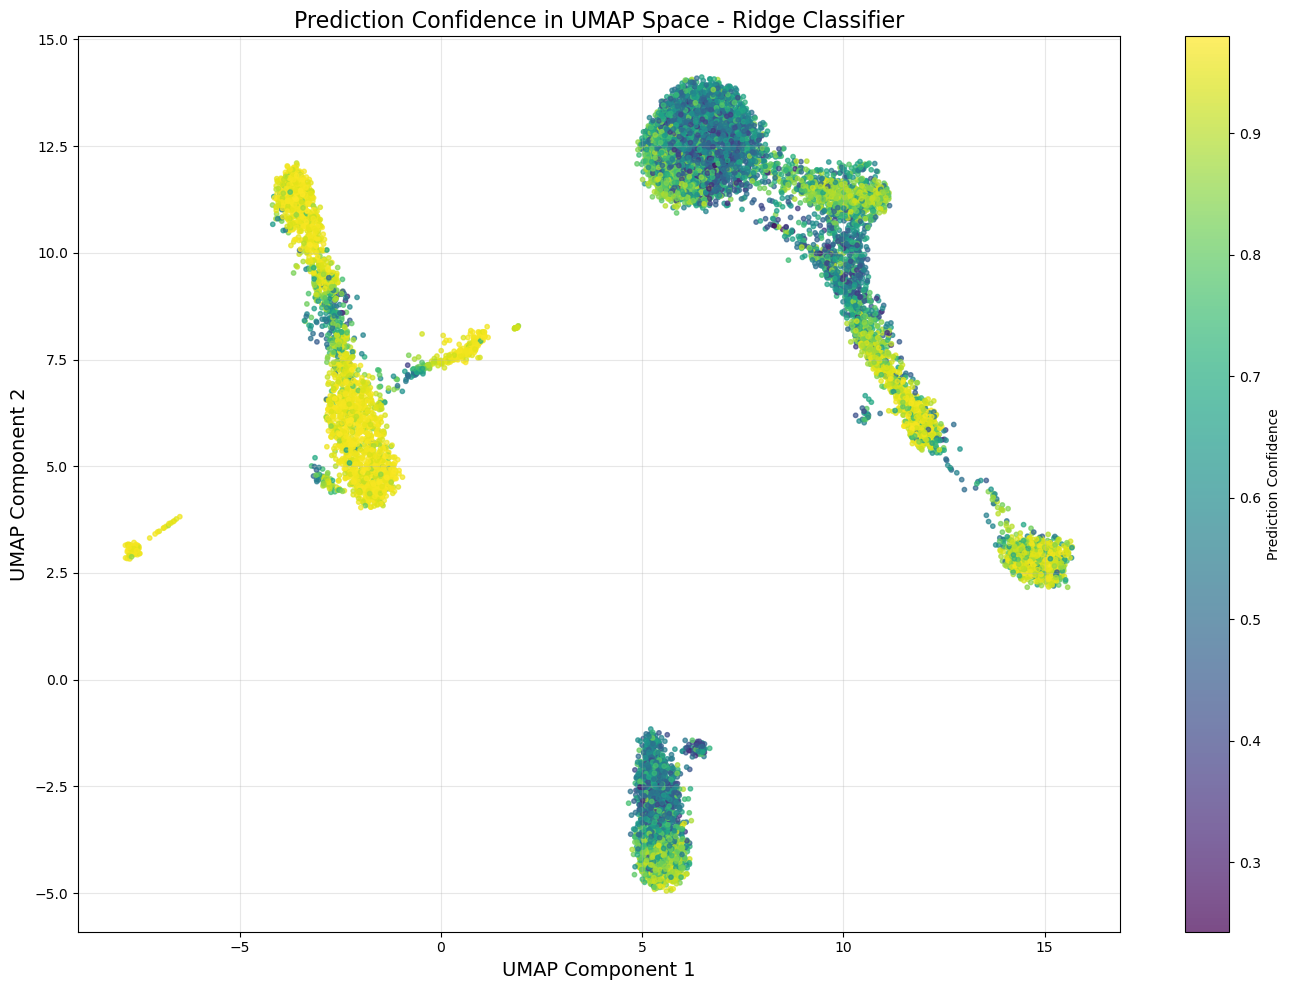

In [13]:
# Get prediction confidence for each sample
prediction_confidence = np.max(y_val_proba_ridge, axis=1)
correct_mask = (y_val_pred_ridge == y_val)

# Create DataFrame for analysis
confidence_df = pd.DataFrame({
    'Confidence': prediction_confidence,
    'Correct': correct_mask,
    'Cell_Type': label_encoder.inverse_transform(y_val)
})

# Plot confidence distributions for correct and incorrect predictions
plt.figure(figsize=(12, 6))
sns.histplot(
    data=confidence_df, x='Confidence', hue='Correct', 
    bins=30, alpha=0.6, palette={True: 'green', False: 'red'}, 
    element="step", common_norm=False, stat='density'
)
plt.title("Prediction Confidence Distribution - Ridge Classifier", fontsize=16)
plt.xlabel("Prediction Confidence", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(['Correct Predictions', 'Incorrect Predictions'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'ridge_confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualize confidence levels in UMAP space
plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    X_val_umap[:, 0], 
    X_val_umap[:, 1],
    c=prediction_confidence, 
    cmap='viridis', 
    s=10, 
    alpha=0.7
)
plt.colorbar(scatter, label='Prediction Confidence')
plt.title("Prediction Confidence in UMAP Space - Ridge Classifier", fontsize=16)
plt.xlabel("UMAP Component 1", fontsize=14)
plt.ylabel("UMAP Component 2", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'ridge_confidence_umap.png'), dpi=300, bbox_inches='tight')
plt.show()

##### Evaluation on Test Set and Model Persistence

In [14]:
# Final evaluation on test set
print("\nEvaluating Ridge Classifier on test set...")
y_test_pred_ridge = ridge_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_ridge)
test_f1_weighted = f1_score(y_test, y_test_pred_ridge, average='weighted')
test_f1_macro = f1_score(y_test, y_test_pred_ridge, average='macro')

print(f"\nTest Set Performance:")
print(f"Overall Accuracy: {test_accuracy:.4f}")
print(f"Weighted F1-Score: {test_f1_weighted:.4f}")
print(f"Macro F1-Score: {test_f1_macro:.4f}")

# Save the model
joblib.dump(ridge_pipeline, os.path.join(MODEL_DIR, 'ridge_classifier_model.pkl'))
joblib.dump(calibrated_ridge, os.path.join(MODEL_DIR, 'calibrated_ridge_classifier_model.pkl'))
print("\nRidge Classifier models saved successfully.")

# Save performance metrics
performance_metrics = {
    'model': 'Ridge Classifier',
    'validation_accuracy': accuracy,
    'validation_f1_weighted': weighted_f1,
    'validation_f1_macro': macro_f1,
    'test_accuracy': test_accuracy,
    'test_f1_weighted': test_f1_weighted,
    'test_f1_macro': test_f1_macro
}

# Save as CSV for easy reference
pd.DataFrame([performance_metrics]).to_csv(
    os.path.join(RESULTS_DIR, 'ridge_classifier_performance.csv'), index=False
)
print("Performance metrics saved to CSV file.")


Evaluating Ridge Classifier on test set...

Test Set Performance:
Overall Accuracy: 0.7814
Weighted F1-Score: 0.7817
Macro F1-Score: 0.7214

Ridge Classifier models saved successfully.
Performance metrics saved to CSV file.


##### Save Ridge Classifier Model

In [39]:
# Save the ridge classifier models in a dedicated folder
os.makedirs(os.path.join(MODEL_DIR, 'Linear_ridge_classifiers'), exist_ok=True)

# Save the standard ridge classifier
ridge_model_path = os.path.join(MODEL_DIR, 'Linear_ridge_classifiers', 'ridge_classifier.pkl')
joblib.dump(ridge_pipeline, ridge_model_path)
print(f"Ridge classifier model saved to {ridge_model_path}")

# Save the calibrated model
calibrated_model_path = os.path.join(MODEL_DIR, 'Linear_ridge_classifiers', 'calibrated_ridge_classifier.pkl')
joblib.dump(calibrated_ridge, calibrated_model_path)
print(f"Calibrated Ridge classifier model saved to {calibrated_model_path}")

Ridge classifier model saved to /mnt/f/cwd_ml/cs7641/Models/Linear_ridge_classifiers/ridge_classifier.pkl
Calibrated Ridge classifier model saved to /mnt/f/cwd_ml/cs7641/Models/Linear_ridge_classifiers/calibrated_ridge_classifier.pkl


----

## Logistic Regression Classifier Model (Sklearn)

### Building and Training LogReg Classifier using Scikit-learn Pipeline

#### L1 vs L2 Regularization for Logistic Regression in RNA-seq Classification

When building classification models for single-cell RNA-seq data, choosing the appropriate regularization technique can significantly impact model performance and interpretability.

##### L1 (Lasso) Regularization

**Key Characteristics:**
- **Feature Selection:** Creates sparse models by forcing some coefficients to exactly zero
- **Mathematical Form:** Adds a penalty term proportional to the absolute value of coefficients (|β|)
- **Implementation:** `LogisticRegression(penalty='l1', solver='liblinear')` in scikit-learn

**Ideal For RNA-seq:**
- When we want to identify a minimal signature of marker genes for each cell type
- When our dataset contains thousands of genes but only a subset are biologically relevant
- When the computational resources are limited and dimensionality reduction is necessary
- When we want a highly interpretable model for downstream biological validation

##### L2 (Ridge) Regularization

**Key Characteristics:**
- **Weight Shrinkage:** Penalizes large coefficients proportionally without eliminating features
- **Mathematical Form:** Adds a penalty term proportional to the square of coefficients (β²)
- **Implementation:** `LogisticRegression(penalty='l2')` in scikit-learn (default option)

**Ideal For RNA-seq:**
- Gene expression patterns show high correlation (common in co-regulated pathways)
- When we want to retain information from all genes rather than select a subset
- When the dataset has more samples than features
- When we want to prioritize prediction accuracy over feature selection



##### L1 Regularization Logistic Regression Classifier

In [19]:
# Create Logistic Regression Classifier with scaling and class weights (L1 regularization)
lr_l1_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(
        C=1.0,
        class_weight=class_weights,
        max_iter=1000,
        solver='saga',  # Works with both L1 and L2
        penalty='l1',   # Lasso regularization
        random_state=RAND_SEED,
        n_jobs=-1,  # Parallel processing
        verbose=1       # Enable verbose output to monitor iterations
    ))
])

print("Training Logistic Regression (L1) classifier...")
start_time = time.time()
lr_l1_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Get predictions on validation set
print("Generating predictions on validation set...")
y_val_pred_lr_l1 = lr_l1_pipeline.predict(X_val)
y_val_proba_lr_l1 = lr_l1_pipeline.predict_proba(X_val)

print("\nLogistic Regression (L1) - Classification Report")
print(classification_report(y_val, y_val_pred_lr_l1, target_names=label_encoder.classes_))

Training Logistic Regression (L1) classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.22753394
Epoch 3, change: 0.095961593
Epoch 4, change: 0.06215461
Epoch 5, change: 0.041205805
Epoch 6, change: 0.040498734
Epoch 7, change: 0.03296547
Epoch 8, change: 0.02726502
Epoch 9, change: 0.02449321
Epoch 10, change: 0.022699466
Epoch 11, change: 0.021536278
Epoch 12, change: 0.018630762
Epoch 13, change: 0.016076542
Epoch 14, change: 0.015492143
Epoch 15, change: 0.014383102
Epoch 16, change: 0.012065017
Epoch 17, change: 0.012509819
Epoch 18, change: 0.010868583
Epoch 19, change: 0.0094672851
Epoch 20, change: 0.0095239282
Epoch 21, change: 0.0094146682
Epoch 22, change: 0.009357404
Epoch 23, change: 0.010274437
Epoch 24, change: 0.0090043107
Epoch 25, change: 0.0064888787
Epoch 26, change: 0.0061352425
Epoch 27, change: 0.0061666938
Epoch 28, change: 0.0060365261
Epoch 29, change: 0.0058948821
Epoch 30, change: 0.0059483889
Epoch 31, change: 0.0058800373
Epoch 32, change: 0.0058142333
Epoch 33, change: 0.005770938
Epoch 34, change: 0.00

#### Logistic Regression (L1) - Classification Report

| Class            | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| B intermediate   | 0.60      | 0.62   | 0.61     | 523     |
| B memory         | 0.57      | 0.68   | 0.62     | 329     |
| B naive          | 0.90      | 0.83   | 0.86     | 1148    |
| CD14 Mono        | 0.98      | 0.97   | 0.97     | 1450    |
| CD16 Mono        | 0.97      | 0.98   | 0.98     | 953     |
| CD4 Naive        | 0.63      | 0.74   | 0.68     | 1067    |
| CD4 TCM          | 0.81      | 0.54   | 0.65     | 1387    |
| CD4 TEM          | 0.41      | 0.72   | 0.52     | 200     |
| CD8 Naive        | 0.81      | 0.82   | 0.82     | 1361    |
| CD8 TCM          | 0.55      | 0.64   | 0.59     | 360     |
| CD8 TEM          | 0.96      | 0.85   | 0.90     | 1296    |
| Dendritic cells  | 0.96      | 0.97   | 0.96     | 394     |
| NK               | 0.97      | 0.98   | 0.98     | 913     |
| Treg             | 0.38      | 0.78   | 0.51     | 153     |
|------------------|-----------|--------|----------|---------|
| **Accuracy**         |           |        | 0.81     | 11534   |
| **Macro avg**        | 0.75      | 0.79   | 0.76     | 11534   |
| **Weighted avg**     | 0.83      | 0.81   | 0.82     | 11534   |

##### L2 Regularization Logistic Regression Classifier

In [18]:
# Create Logistic Regression Classifier with scaling and class weights (L2 regularization)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', LogisticRegression(
        C=1.0,  # Inverse of regularization strength
        class_weight=class_weights,
        max_iter=1000,  # Increase if needed for convergence
        solver='saga',  # Efficient for multi-class problems
        penalty='l2',   # Ridge (L2) regularization
        random_state=RAND_SEED,
        n_jobs=-1,      # Parallel processing
        verbose=1       # Enable verbose output to monitor iterations
    ))
])

print("Training Logistic Regression classifier...")
start_time = time.time()
lr_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Get predictions on validation set
print("Generating predictions on validation set...")
y_val_pred_lr = lr_pipeline.predict(X_val)
y_val_proba_lr = lr_pipeline.predict_proba(X_val)

print("\nLogistic Regression (L2) - Classification Report")
print(classification_report(y_val, y_val_pred_lr, target_names=label_encoder.classes_))

Training Logistic Regression classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.2295268
Epoch 3, change: 0.093519174
Epoch 4, change: 0.061049581
Epoch 5, change: 0.040890519
Epoch 6, change: 0.042131312
Epoch 7, change: 0.032196742
Epoch 8, change: 0.02559275
Epoch 9, change: 0.023313299
Epoch 10, change: 0.022017315
Epoch 11, change: 0.019320112
Epoch 12, change: 0.017663106
Epoch 13, change: 0.01528163
Epoch 14, change: 0.014585964
Epoch 15, change: 0.013008536
Epoch 16, change: 0.012150439
Epoch 17, change: 0.01150641
Epoch 18, change: 0.0099927168
Epoch 19, change: 0.0086125219
Epoch 20, change: 0.0087605165
Epoch 21, change: 0.0083344877
Epoch 22, change: 0.0084518204
Epoch 23, change: 0.0076617594
Epoch 24, change: 0.0077685886
Epoch 25, change: 0.0065572821
Epoch 26, change: 0.005945859
Epoch 27, change: 0.0058839219
Epoch 28, change: 0.0057668802
Epoch 29, change: 0.0056855199
Epoch 30, change: 0.0057808417
Epoch 31, change: 0.005533223
Epoch 32, change: 0.0055601299
Epoch 33, change: 0.0055329646
Epoch 34, change: 0.

#### Logistic Regression (L2) - Classification Report

| Class            | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| B intermediate   | 0.60      | 0.62   | 0.61     | 523     |
| B memory         | 0.57      | 0.68   | 0.62     | 329     |
| B naive          | 0.90      | 0.83   | 0.87     | 1148    |
| CD14 Mono        | 0.98      | 0.97   | 0.97     | 1450    |
| CD16 Mono        | 0.97      | 0.98   | 0.97     | 953     |
| CD4 Naive        | 0.63      | 0.74   | 0.68     | 1067    |
| CD4 TCM          | 0.81      | 0.54   | 0.65     | 1387    |
| CD4 TEM          | 0.41      | 0.72   | 0.52     | 200     |
| CD8 Naive        | 0.81      | 0.82   | 0.81     | 1361    |
| CD8 TCM          | 0.55      | 0.64   | 0.59     | 360     |
| CD8 TEM          | 0.96      | 0.85   | 0.90     | 1296    |
| Dendritic cells  | 0.96      | 0.97   | 0.96     | 394     |
| NK               | 0.97      | 0.98   | 0.98     | 913     |
| Treg             | 0.37      | 0.77   | 0.50     | 153     |
|------------------|-----------|--------|----------|---------|
| **Accuracy**         |           |        | 0.81     | 11534   |
| **Macro avg**       | 0.75      | 0.79   | 0.76     | 11534   |
| **Weighted avg**    | 0.83      | 0.81   | 0.82     | 11534   |

In [22]:
# Performance Metrics
# Calculate overall accuracy for both models
accuracy_l1 = accuracy_score(y_val, y_val_pred_lr_l1)
weighted_f1_l1 = f1_score(y_val, y_val_pred_lr_l1, average='weighted')
macro_f1_l1 = f1_score(y_val, y_val_pred_lr_l1, average='macro')

accuracy_l2 = accuracy_score(y_val, y_val_pred_lr)
weighted_f1_l2 = f1_score(y_val, y_val_pred_lr, average='weighted')
macro_f1_l2 = f1_score(y_val, y_val_pred_lr, average='macro')

# Print comparison of overall metrics
print("Comparative Performance - L1 vs L2 Regularization:")
print(f"{'Metric':<20}{'L1 (Lasso)':<15}{'L2 (Ridge)':<15}{'Difference':<15}")
print("-" * 65)
print(f"{'Accuracy':<20}{accuracy_l1:.4f}{'':<7}{accuracy_l2:.4f}{'':<7}{(accuracy_l1-accuracy_l2):.4f}")
print(f"{'Weighted F1-Score':<20}{weighted_f1_l1:.4f}{'':<7}{weighted_f1_l2:.4f}{'':<7}{(weighted_f1_l1-weighted_f1_l2):.4f}")
print(f"{'Macro F1-Score':<20}{macro_f1_l1:.4f}{'':<7}{macro_f1_l2:.4f}{'':<7}{(macro_f1_l1-macro_f1_l2):.4f}")

# Per-class performance for L1
class_report_l1 = classification_report(y_val, y_val_pred_lr_l1, 
                                    target_names=label_encoder.classes_,
                                    output_dict=True)
class_metrics_l1 = pd.DataFrame(class_report_l1).T

# Per-class performance for L2
class_report_l2 = classification_report(y_val, y_val_pred_lr, 
                                    target_names=label_encoder.classes_,
                                    output_dict=True)
class_metrics_l2 = pd.DataFrame(class_report_l2).T

# Create a comparison DataFrame
class_comparison = pd.DataFrame()
for cell_type in label_encoder.classes_:
    l1_f1 = class_metrics_l1.loc[cell_type, 'f1-score'] 
    l2_f1 = class_metrics_l2.loc[cell_type, 'f1-score']
    diff = l1_f1 - l2_f1
    class_comparison.loc[cell_type, 'F1-Score (L1)'] = l1_f1
    class_comparison.loc[cell_type, 'F1-Score (L2)'] = l2_f1
    class_comparison.loc[cell_type, 'Difference'] = diff
    class_comparison.loc[cell_type, 'Support'] = class_metrics_l1.loc[cell_type, 'support']

# Sort by absolute difference to highlight the largest differences
class_comparison['Abs Difference'] = abs(class_comparison['Difference'])
class_comparison = class_comparison.sort_values('Abs Difference', ascending=False)

print("\nCell Type Performance Comparison (F1-Score):")
print(class_comparison[['F1-Score (L1)', 'F1-Score (L2)', 'Difference', 'Support']])

# Calculate feature sparsity for L1 model
l1_coefficients = lr_l1_pipeline.named_steps['logistic'].coef_
l2_coefficients = lr_pipeline.named_steps['logistic'].coef_

l1_sparsity = np.mean(l1_coefficients == 0) * 100
l2_sparsity = np.mean(l2_coefficients == 0) * 100

print(f"\nCoefficient Sparsity:")
print(f"L1 Model: {l1_sparsity:.2f}% zero coefficients")
print(f"L2 Model: {l2_sparsity:.2f}% zero coefficients")


Comparative Performance - L1 vs L2 Regularization:
Metric              L1 (Lasso)     L2 (Ridge)     Difference     
-----------------------------------------------------------------
Accuracy            0.8129       0.8131       -0.0002
Weighted F1-Score   0.8167       0.8170       -0.0003
Macro F1-Score      0.7603       0.7602       0.0001

Cell Type Performance Comparison (F1-Score):
                 F1-Score (L1)  F1-Score (L2)  Difference  Support
Treg                  0.508547       0.503198    0.005349    153.0
CD4 TCM               0.647339       0.649373   -0.002034   1387.0
B intermediate        0.608121       0.610009   -0.001889    523.0
Dendritic cells       0.963522       0.964824   -0.001302    394.0
B memory              0.620690       0.619640    0.001049    329.0
CD16 Mono             0.975483       0.974439    0.001043    953.0
CD8 TEM               0.899631       0.900613   -0.000982   1296.0
B naive               0.864621       0.865402   -0.000781   1148.0
CD8 TCM

##### Detailed Performance Metrics

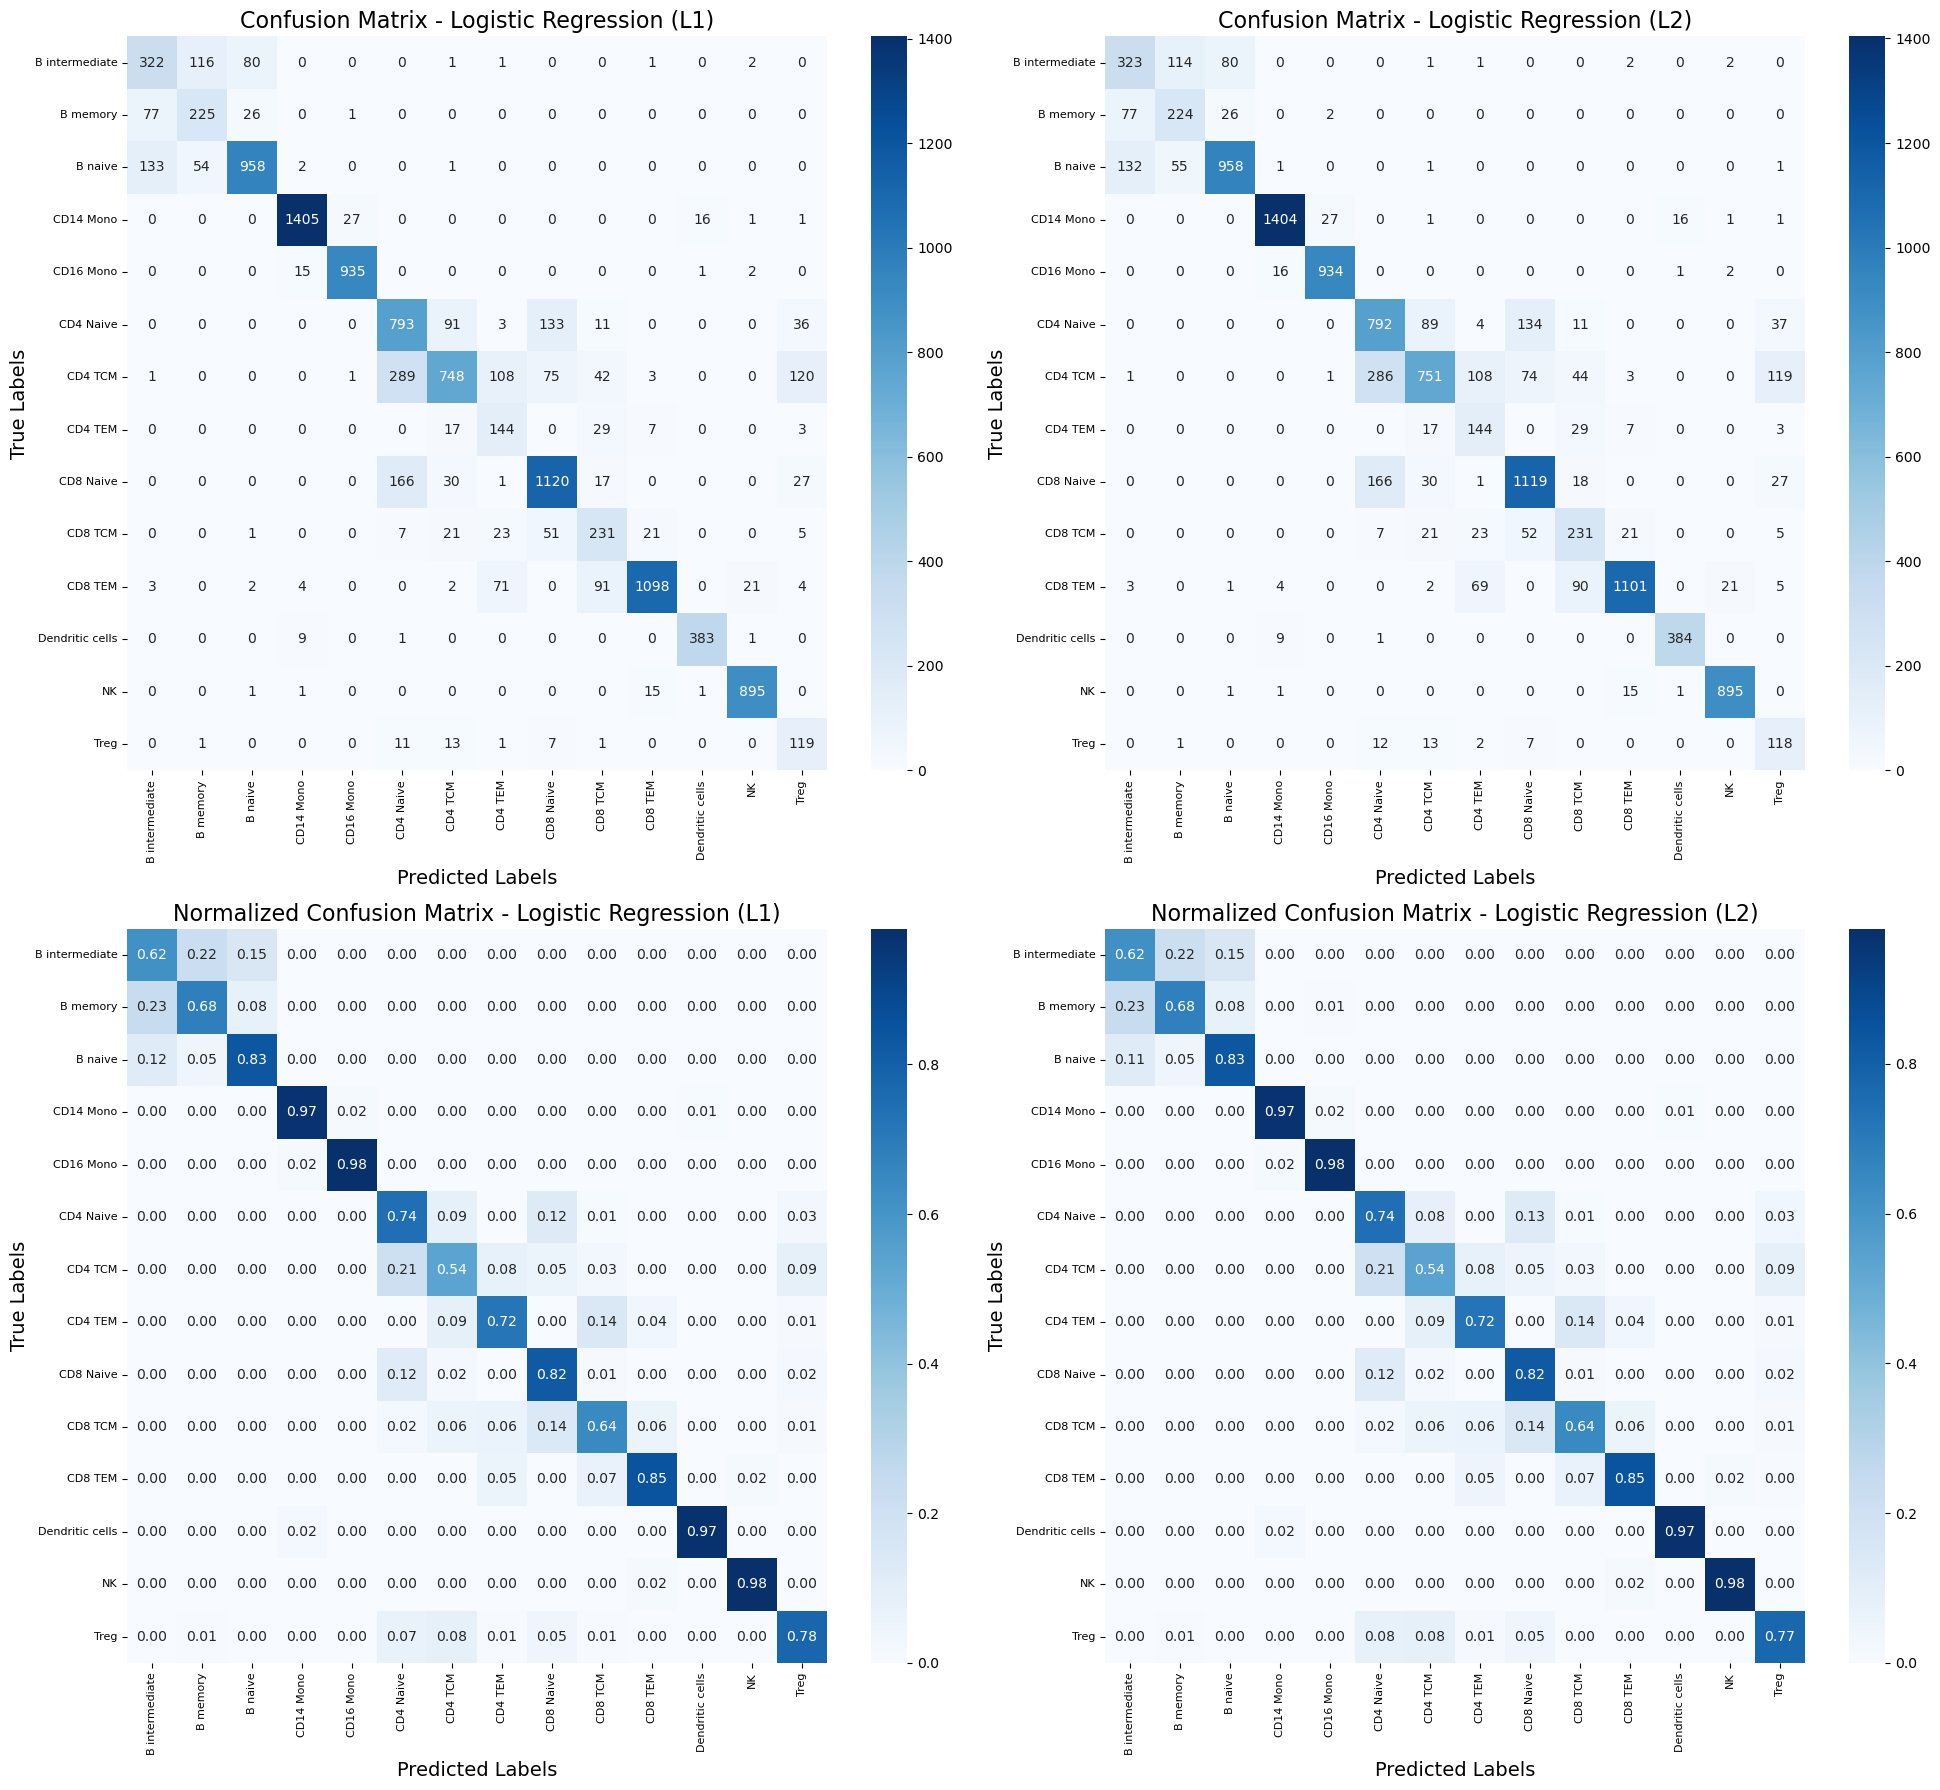

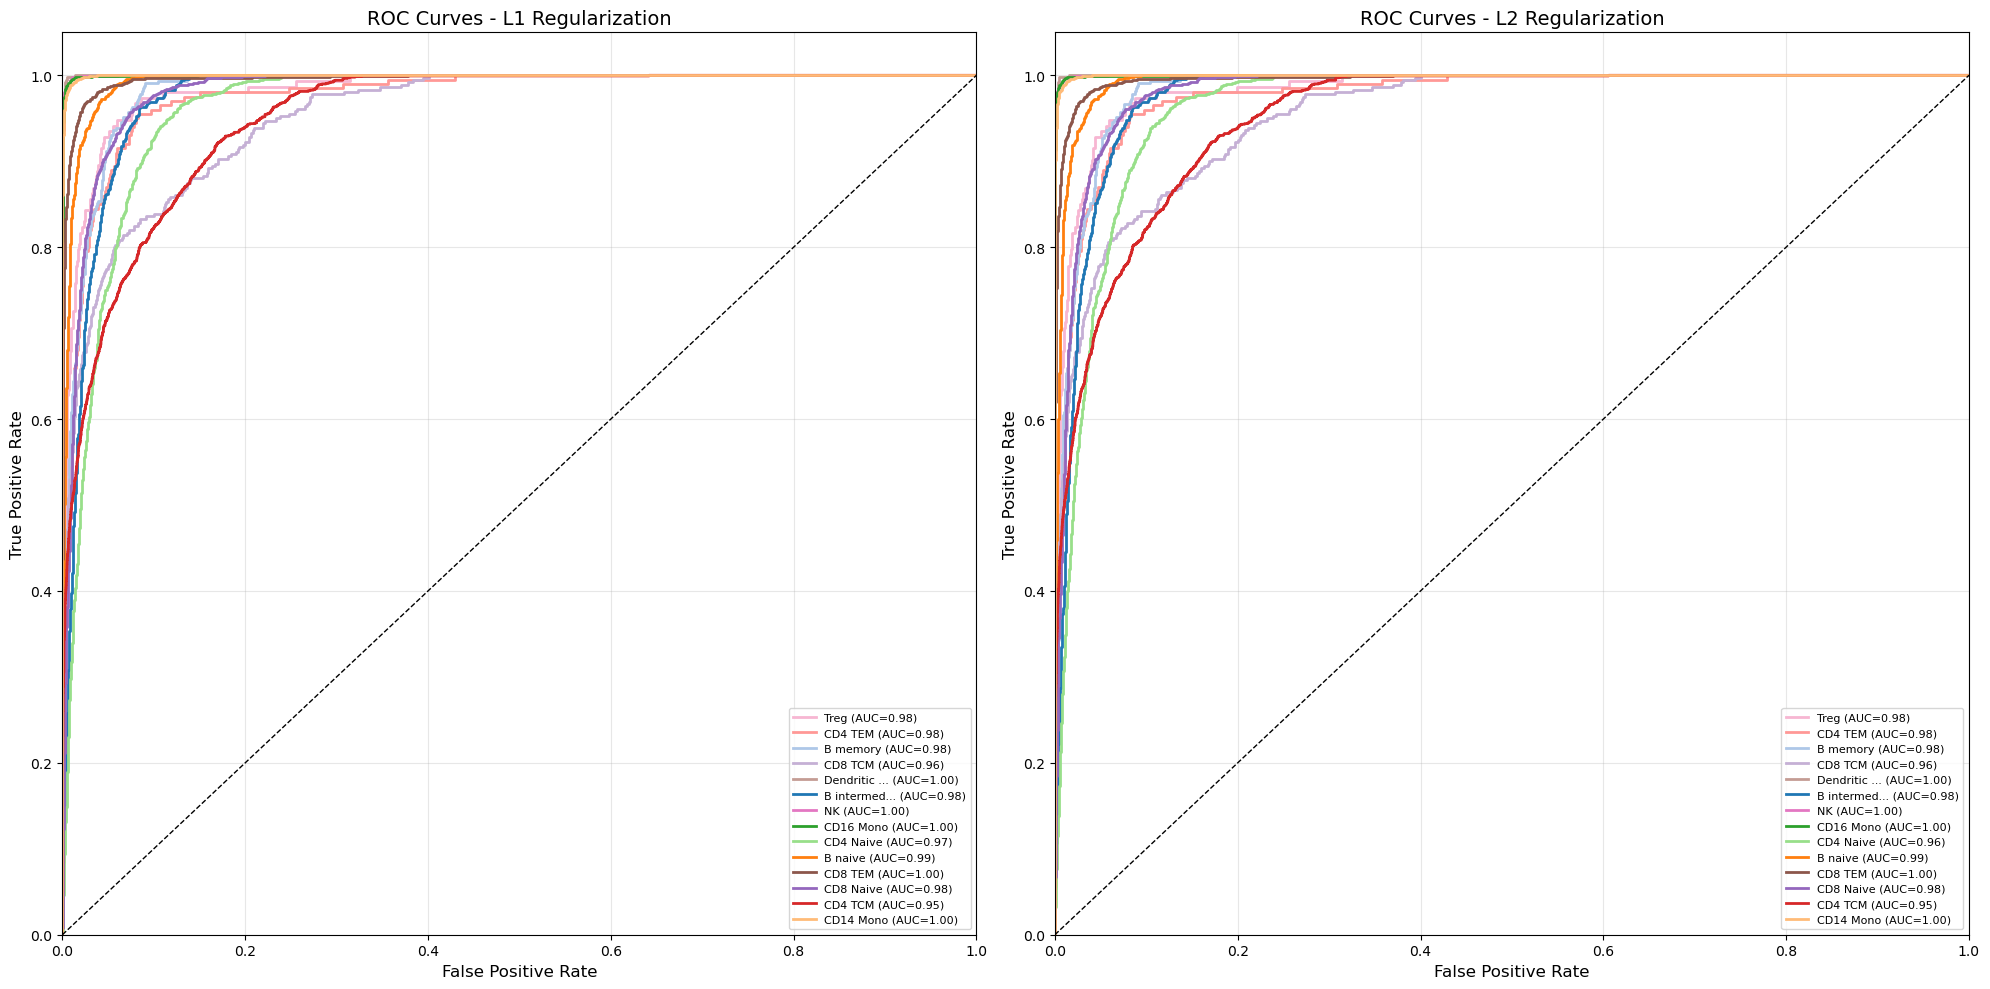

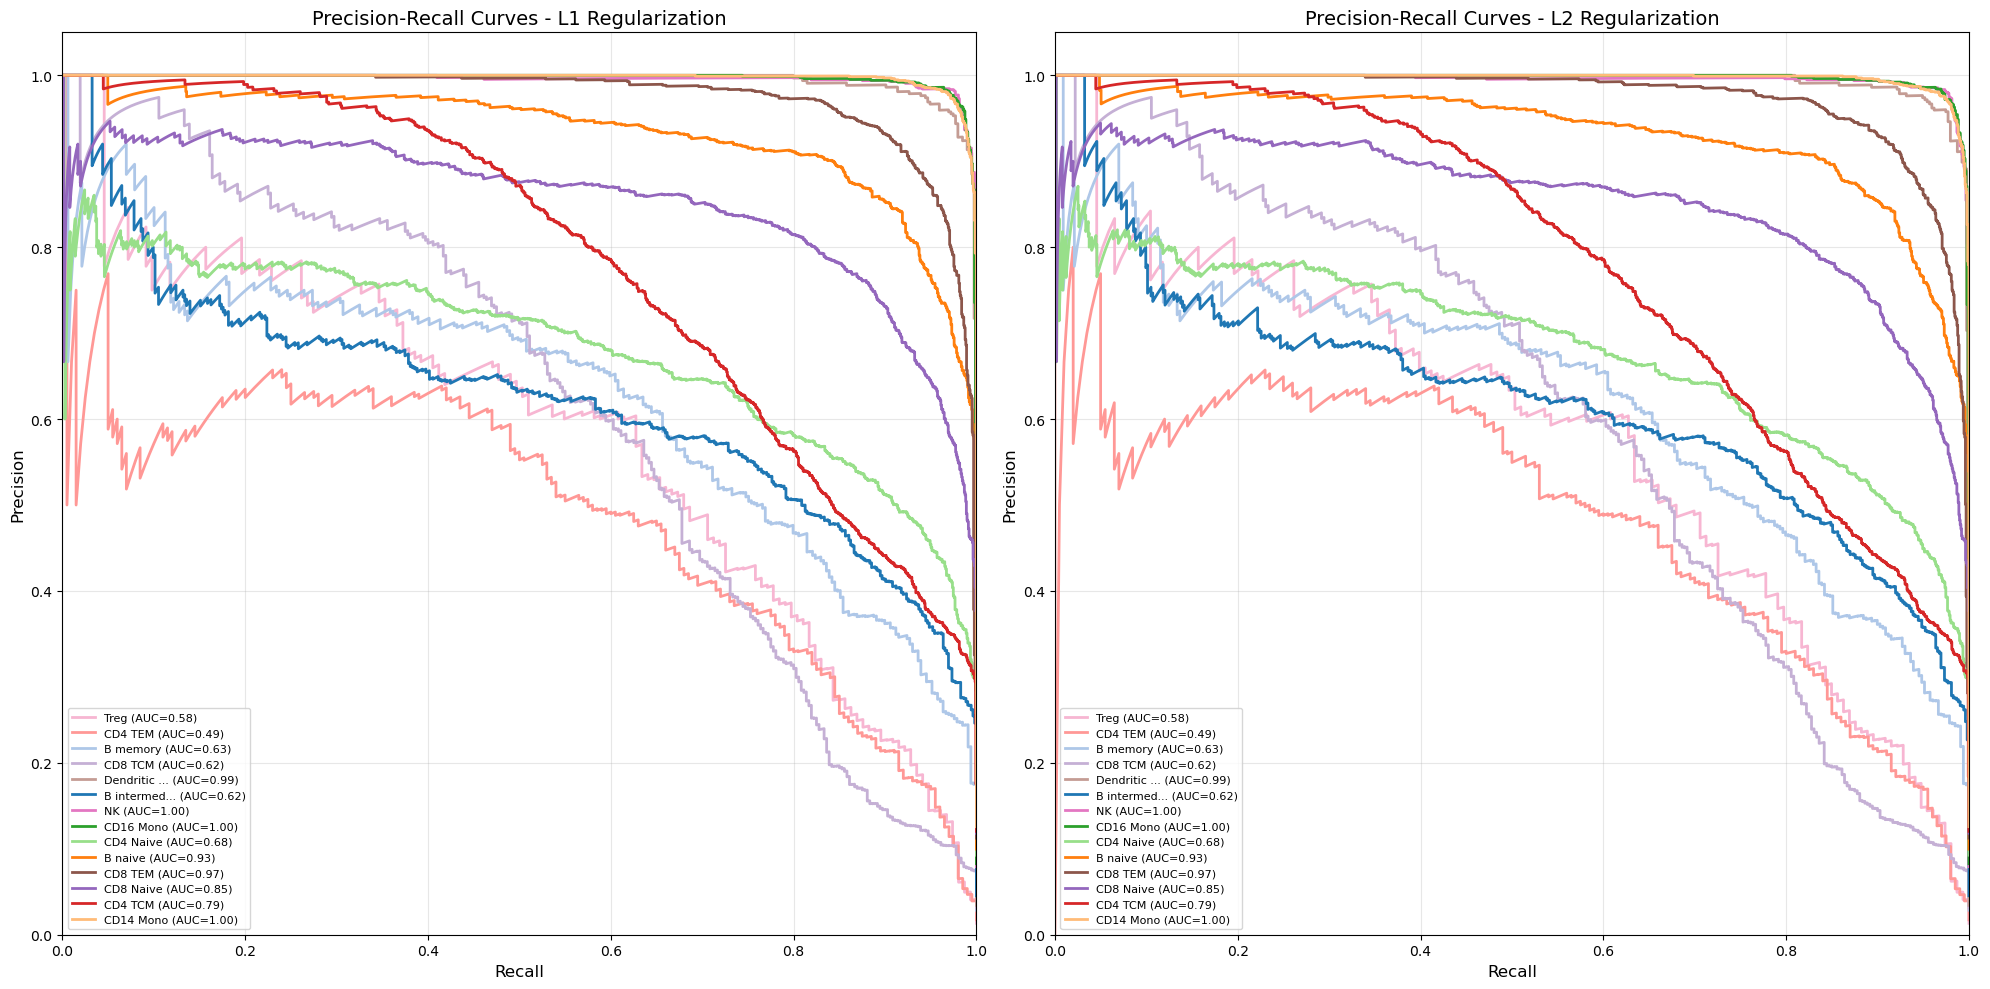

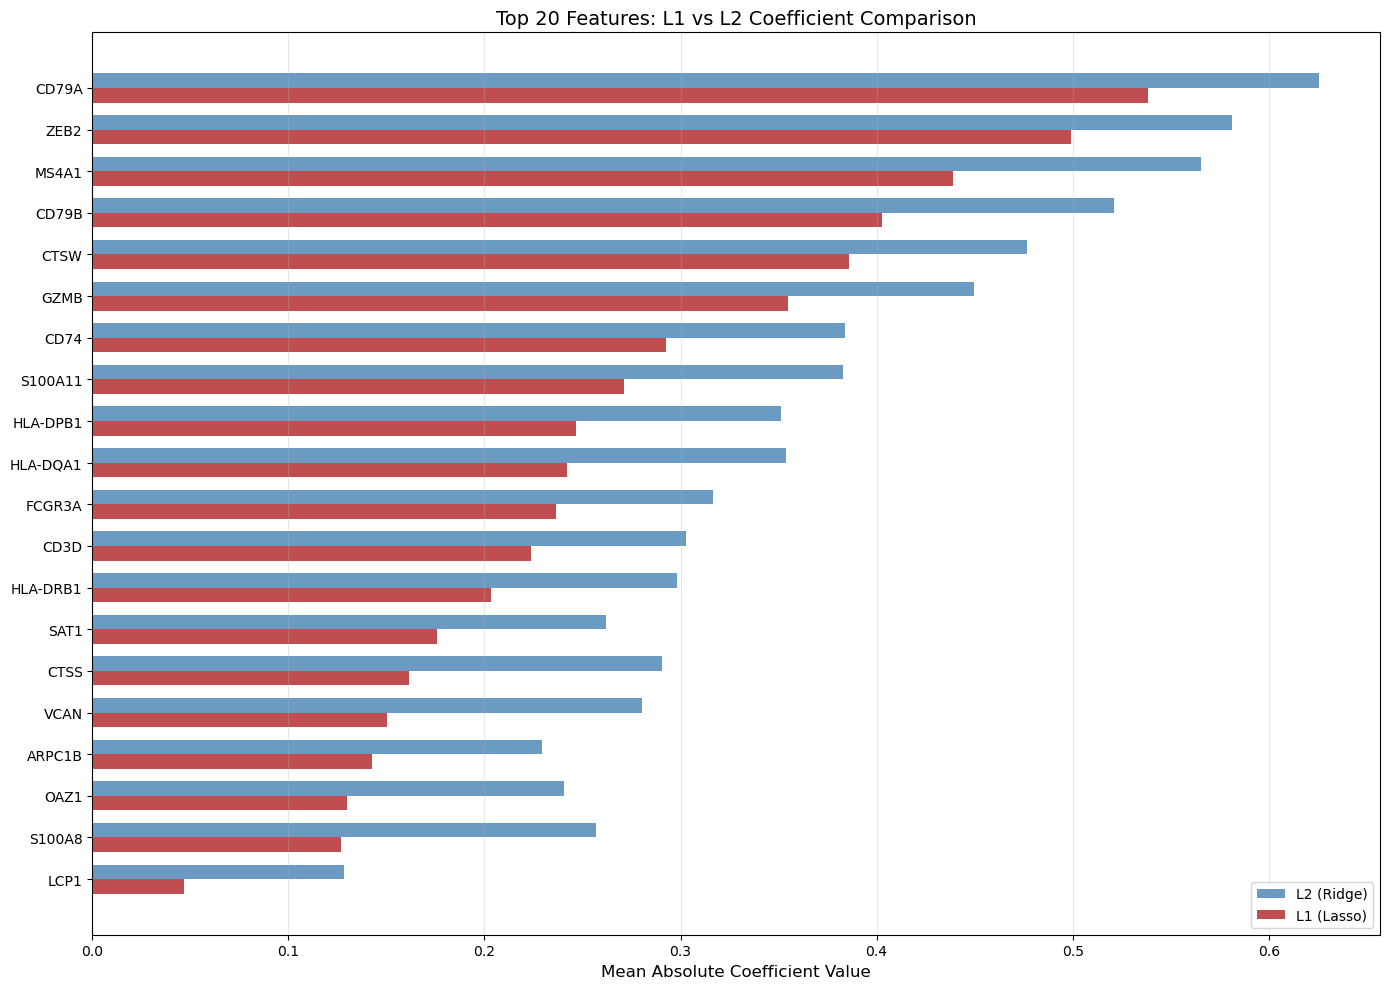

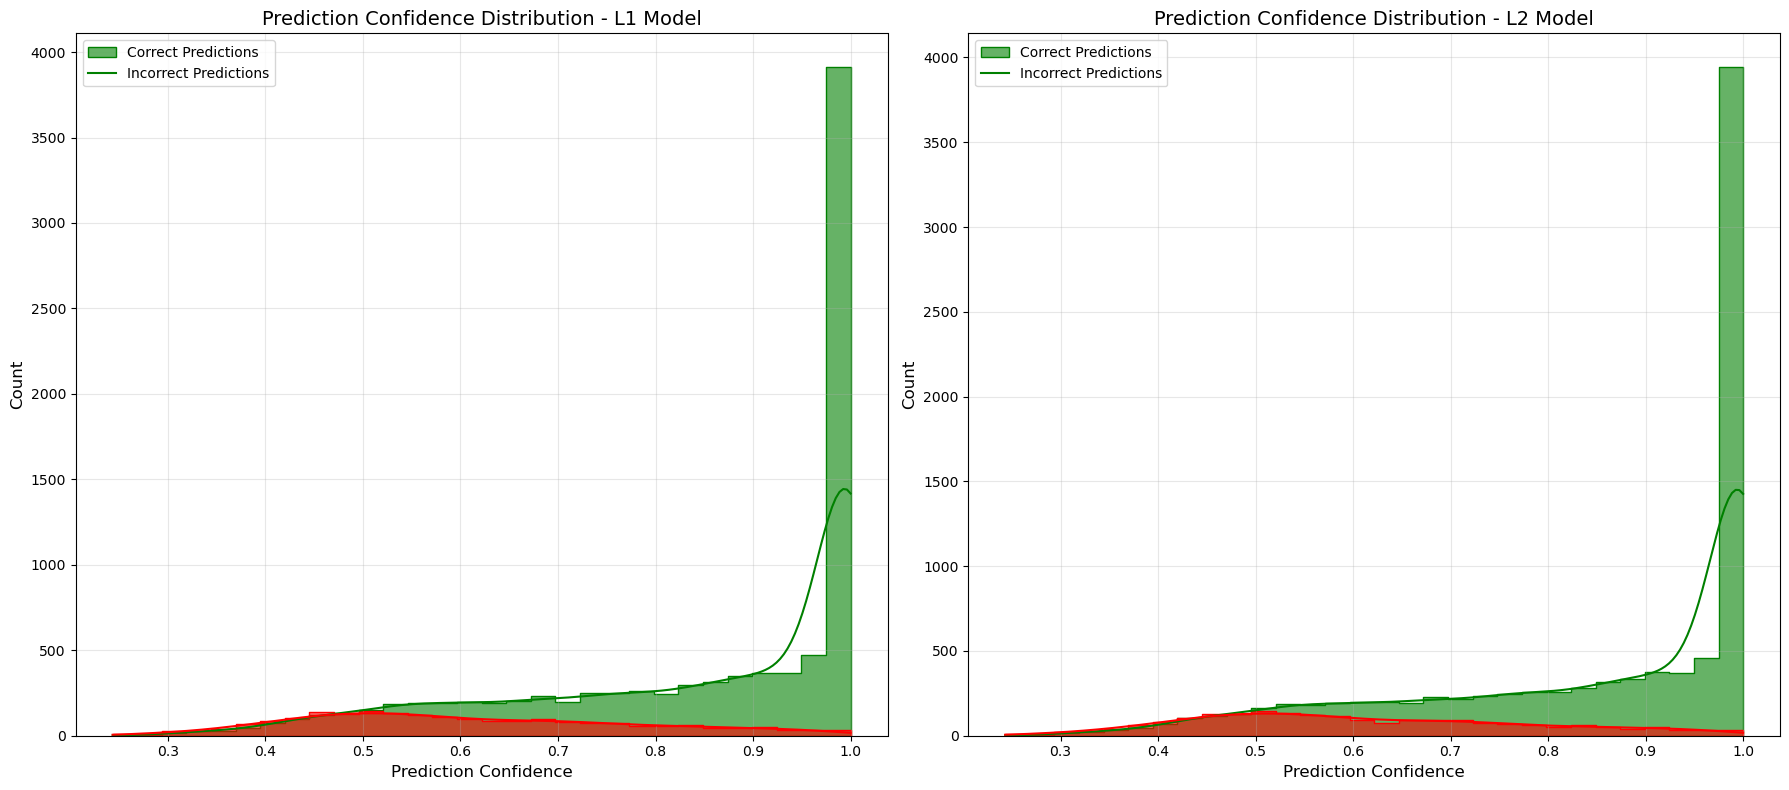

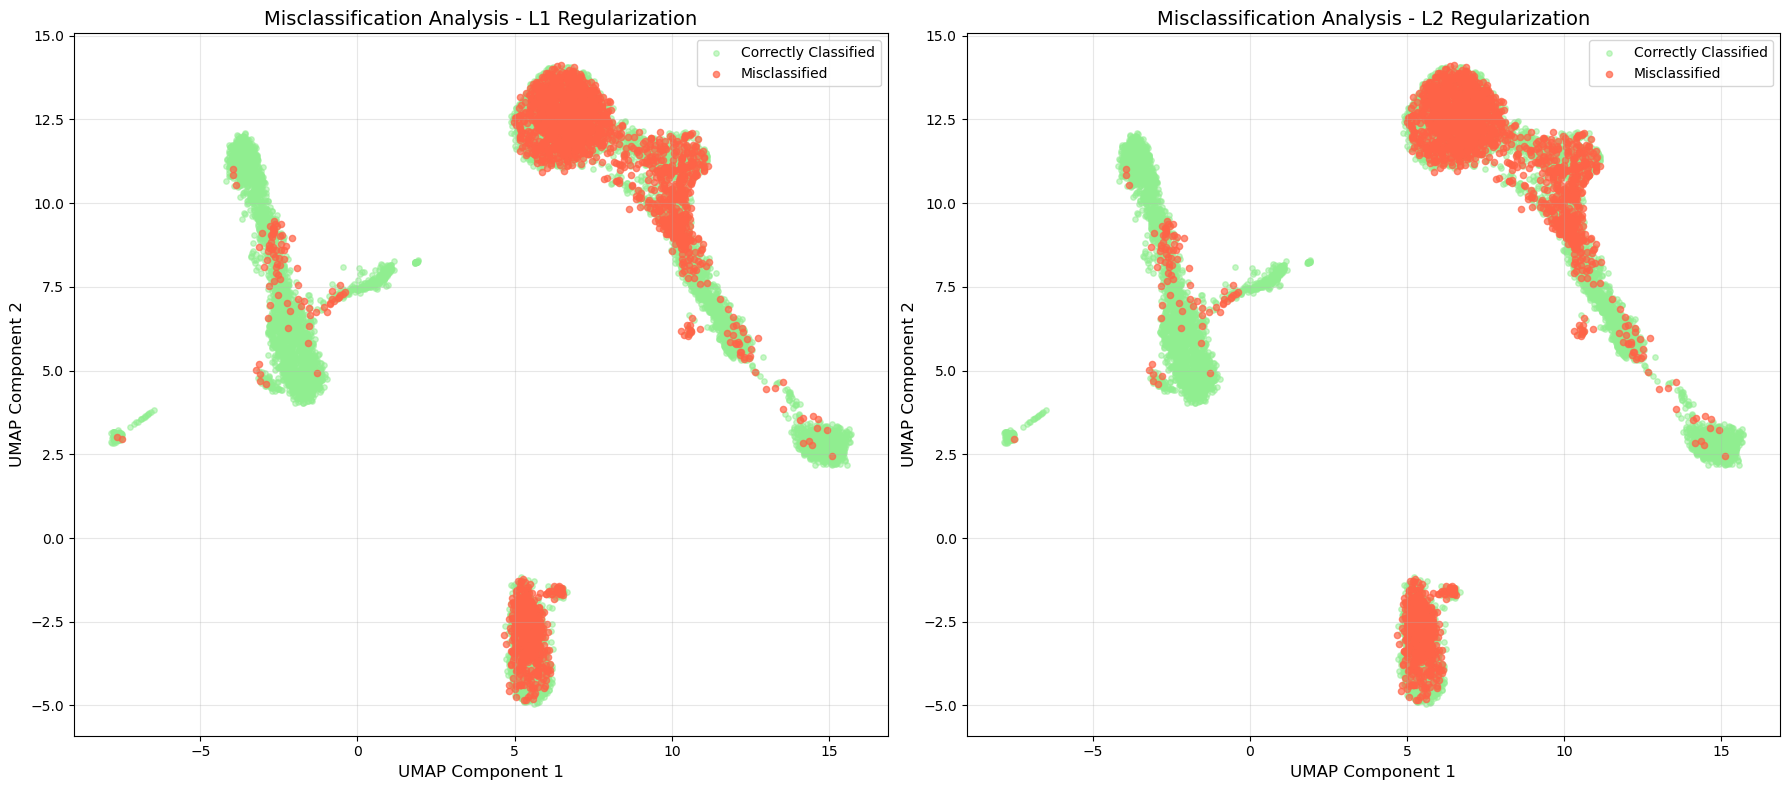

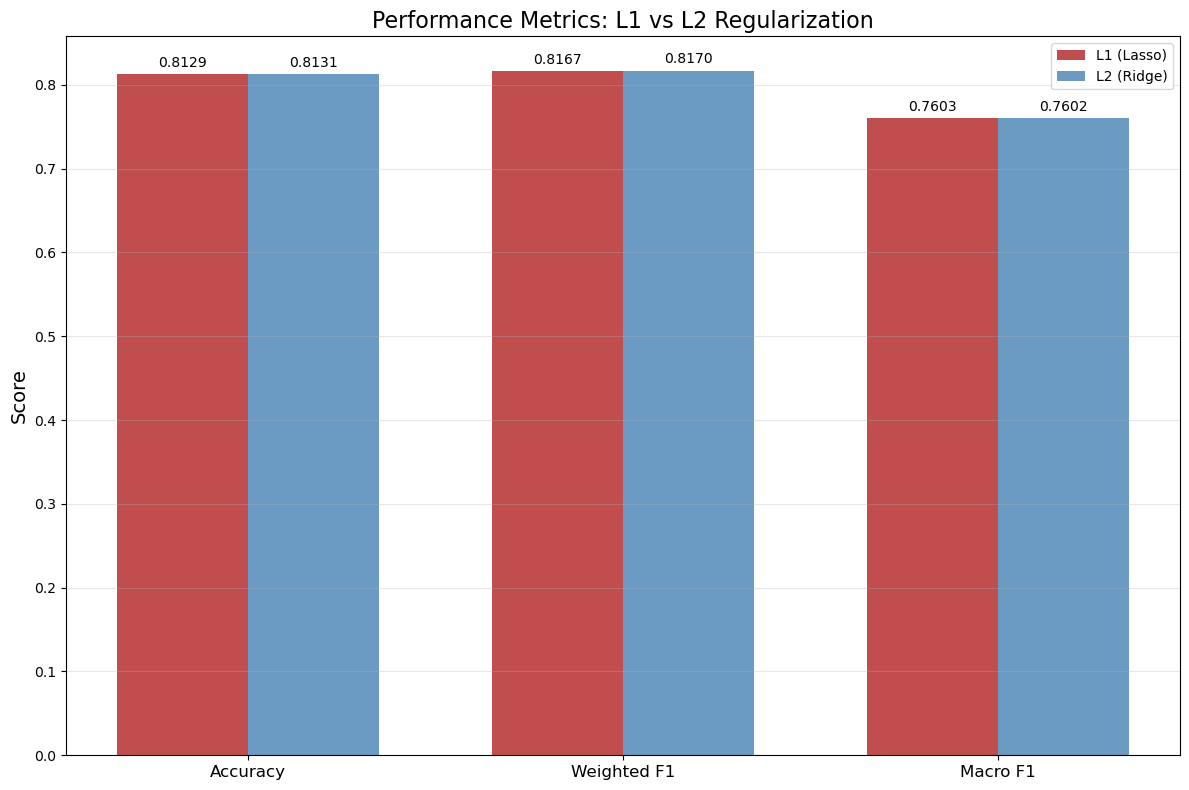


Comparative Performance Analysis: L1 vs L2 Regularization
Metric                   L1 (Lasso)     L2 (Ridge)     Difference     
--------------------------------------------------------------------------------
Accuracy                 0.812901       0.813074       -0.000173
Weighted F1-Score        0.816716       0.816981       -0.000265
Macro F1-Score           0.760327       0.760203       0.000124
Coefficient Sparsity     0.00%       0.00%       0.00%
Non-zero Features        100       100       0
Training Time (sec)      371.62       622.94       -251.32


In [32]:
# Confusion Matrix for Logistic Regression - L1 vs L2 Comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

# L1 Confusion Matrix
cm_l1 = confusion_matrix(y_val, y_val_pred_lr_l1)
sns.heatmap(cm_l1, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            ax=axes[0, 0])
axes[0, 0].set_title("Confusion Matrix - Logistic Regression (L1)", fontsize=16)
axes[0, 0].set_xlabel('Predicted Labels', fontsize=14)
axes[0, 0].set_ylabel('True Labels', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=90, labelsize=8)
axes[0, 0].tick_params(axis='y', labelsize=8)

# L2 Confusion Matrix
cm_l2 = confusion_matrix(y_val, y_val_pred_lr)
sns.heatmap(cm_l2, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            ax=axes[0, 1])
axes[0, 1].set_title("Confusion Matrix - Logistic Regression (L2)", fontsize=16)
axes[0, 1].set_xlabel('Predicted Labels', fontsize=14)
axes[0, 1].set_ylabel('True Labels', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=90, labelsize=8)
axes[0, 1].tick_params(axis='y', labelsize=8)

# L1 Normalized Confusion Matrix
cm_normalized_l1 = cm_l1.astype('float') / cm_l1.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized_l1, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            ax=axes[1, 0])
axes[1, 0].set_title("Normalized Confusion Matrix - Logistic Regression (L1)", fontsize=16)
axes[1, 0].set_xlabel('Predicted Labels', fontsize=14)
axes[1, 0].set_ylabel('True Labels', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)
axes[1, 0].tick_params(axis='y', labelsize=8)

# L2 Normalized Confusion Matrix
cm_normalized_l2 = cm_l2.astype('float') / cm_l2.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized_l2, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            ax=axes[1, 1])
axes[1, 1].set_title("Normalized Confusion Matrix - Logistic Regression (L2)", fontsize=16)
axes[1, 1].set_xlabel('Predicted Labels', fontsize=14)
axes[1, 1].set_ylabel('True Labels', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=90, labelsize=8)
axes[1, 1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_confusion_matrix_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create separate ROC curve visualizations for L1 and L2
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Get top classes by support
class_supports = np.bincount(y_val)
all_classes = np.argsort(class_supports)[-14:]  # Top 14 classes by support

# L1 ROC curves
for i in all_classes:
    if i < n_classes:  # Ensure class index is valid
        fpr_l1, tpr_l1, _ = roc_curve(y_val_bin[:, i], y_val_proba_lr_l1[:, i])
        roc_auc_l1 = auc(fpr_l1, tpr_l1)
        class_name = label_encoder.classes_[i]
        if len(class_name) > 12:
            class_name = class_name[:10] + '...'
        axes[0].plot(fpr_l1, tpr_l1, lw=2, 
                color=color_palette[i % len(color_palette)],
                label=f'{class_name} (AUC={roc_auc_l1:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves - L1 Regularization', fontsize=14)
axes[0].legend(loc='lower right', fontsize=8)
axes[0].grid(alpha=0.3)

# L2 ROC curves
for i in all_classes:
    if i < n_classes:  # Ensure class index is valid
        fpr_l2, tpr_l2, _ = roc_curve(y_val_bin[:, i], y_val_proba_lr[:, i])
        roc_auc_l2 = auc(fpr_l2, tpr_l2)
        class_name = label_encoder.classes_[i]
        if len(class_name) > 12:
            class_name = class_name[:10] + '...'
        axes[1].plot(fpr_l2, tpr_l2, lw=2, 
                color=color_palette[i % len(color_palette)],
                label=f'{class_name} (AUC={roc_auc_l2:.2f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curves - L2 Regularization', fontsize=14)
axes[1].legend(loc='lower right', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_roc_curves_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Precision-Recall curves for L1
for i in all_classes:
    if i < n_classes:  # Ensure class index is valid
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_val_proba_lr_l1[:, i])
        pr_auc = auc(recall, precision)
        class_name = label_encoder.classes_[i]
        if len(class_name) > 12:
            class_name = class_name[:10] + '...'
        axes[0].plot(recall, precision, lw=2, 
                color=color_palette[i % len(color_palette)],
                label=f'{class_name} (AUC={pr_auc:.2f})')

axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curves - L1 Regularization', fontsize=14)
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(alpha=0.3)

# Precision-Recall curves for L2
for i in all_classes:
    if i < n_classes:  # Ensure class index is valid
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_val_proba_lr[:, i])
        pr_auc = auc(recall, precision)
        class_name = label_encoder.classes_[i]
        if len(class_name) > 12:
            class_name = class_name[:10] + '...'
        axes[1].plot(recall, precision, lw=2, 
                color=color_palette[i % len(color_palette)],
                label=f'{class_name} (AUC={pr_auc:.2f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves - L2 Regularization', fontsize=14)
axes[1].legend(loc='best', fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_precision_recall_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Feature importance comparison
l1_coef = np.abs(lr_l1_pipeline.named_steps['logistic'].coef_).mean(axis=0)
l2_coef = np.abs(lr_pipeline.named_steps['logistic'].coef_).mean(axis=0)

# Create a DataFrame for comparison
feature_importance_comparison = pd.DataFrame({
    'Feature': feature_genes,
    'L1_Importance': l1_coef,
    'L2_Importance': l2_coef
})

# Calculate difference and relative difference
feature_importance_comparison['Difference'] = feature_importance_comparison['L1_Importance'] - feature_importance_comparison['L2_Importance']
feature_importance_comparison['Relative_Diff'] = feature_importance_comparison['Difference'] / feature_importance_comparison['L2_Importance']
# Calculate absolute difference before sorting by it
feature_importance_comparison['Absolute_Diff'] = np.abs(feature_importance_comparison['Difference'])

# Sort by difference to see which features are emphasized differently by each model
feature_importance_comparison = feature_importance_comparison.sort_values('Absolute_Diff', ascending=False)

# Plot top 20 features with biggest absolute difference between models
plt.figure(figsize=(14, 10))
comparison_plot = feature_importance_comparison.head(20).sort_values('L1_Importance', ascending=True)

# Plot horizontal bar chart
indices = np.arange(len(comparison_plot))
width = 0.35

plt.barh(indices + width/2, comparison_plot['L2_Importance'], width, 
        color='steelblue', alpha=0.8, label='L2 (Ridge)')
plt.barh(indices - width/2, comparison_plot['L1_Importance'], width, 
        color='firebrick', alpha=0.8, label='L1 (Lasso)')

plt.yticks(indices, comparison_plot['Feature'])
plt.xlabel('Mean Absolute Coefficient Value', fontsize=12)
plt.title('Top 20 Features: L1 vs L2 Coefficient Comparison', fontsize=14)
plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_feature_importance_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Coefficient sparsity visualization
# Get counts of zero coefficients for L1
zero_coeffs_l1 = (l1_coef == 0).sum()
nonzero_coeffs_l1 = len(l1_coef) - zero_coeffs_l1

# Create visualization for prediction confidence comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get confidence for L1 and L2 models
confidence_l1 = np.max(y_val_proba_lr_l1, axis=1)
confidence_l2 = np.max(y_val_proba_lr, axis=1)

# Confidence distribution for L1
sns.histplot(
    x=confidence_l1, hue=(y_val_pred_lr_l1 == y_val), 
    bins=30, alpha=0.6, palette={True: 'green', False: 'red'}, 
    element="step", kde=True, ax=axes[0]
)
axes[0].set_title("Prediction Confidence Distribution - L1 Model", fontsize=14)
axes[0].set_xlabel("Prediction Confidence", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].legend(['Correct Predictions', 'Incorrect Predictions'])
axes[0].grid(alpha=0.3)

# Confidence distribution for L2
sns.histplot(
    x=confidence_l2, hue=(y_val_pred_lr == y_val), 
    bins=30, alpha=0.6, palette={True: 'green', False: 'red'}, 
    element="step", kde=True, ax=axes[1]
)
axes[1].set_title("Prediction Confidence Distribution - L2 Model", fontsize=14)
axes[1].set_xlabel("Prediction Confidence", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].legend(['Correct Predictions', 'Incorrect Predictions'])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_confidence_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create a comparative visualization for misclassifications in UMAP space
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# L1 misclassifications
correct_mask_l1 = (y_val_pred_lr_l1 == y_val)
axes[0].scatter(
    X_val_umap[correct_mask_l1, 0], X_val_umap[correct_mask_l1, 1],
    c='lightgreen', s=15, alpha=0.5, label='Correctly Classified'
)
axes[0].scatter(
    X_val_umap[~correct_mask_l1, 0], X_val_umap[~correct_mask_l1, 1],
    c='tomato', s=20, alpha=0.7, label='Misclassified'
)
axes[0].set_title("Misclassification Analysis - L1 Regularization", fontsize=14)
axes[0].set_xlabel("UMAP Component 1", fontsize=12)
axes[0].set_ylabel("UMAP Component 2", fontsize=12)
axes[0].legend(loc='best')
axes[0].grid(alpha=0.3)

# L2 misclassifications
correct_mask_l2 = (y_val_pred_lr == y_val)
axes[1].scatter(
    X_val_umap[correct_mask_l2, 0], X_val_umap[correct_mask_l2, 1],
    c='lightgreen', s=15, alpha=0.5, label='Correctly Classified'
)
axes[1].scatter(
    X_val_umap[~correct_mask_l2, 0], X_val_umap[~correct_mask_l2, 1],
    c='tomato', s=20, alpha=0.7, label='Misclassified'
)
axes[1].set_title("Misclassification Analysis - L2 Regularization", fontsize=14)
axes[1].set_xlabel("UMAP Component 1", fontsize=12)
axes[1].set_ylabel("UMAP Component 2", fontsize=12)
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_misclassification_umap_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Visualize performance metrics in a bar chart
metrics = ['Accuracy', 'Weighted F1', 'Macro F1']
l1_values = [accuracy_l1, weighted_f1_l1, macro_f1_l1]
l2_values = [accuracy_l2, weighted_f1_l2, macro_f1_l2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, l1_values, width, label='L1 (Lasso)', color='firebrick', alpha=0.8)
rects2 = ax.bar(x + width/2, l2_values, width, label='L2 (Ridge)', color='steelblue', alpha=0.8)

# Add labels and title
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Performance Metrics: L1 vs L2 Regularization', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend()

# Add value labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'comparison_performance_metrics_l1_l2.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate L1 sparsity percentage
l1_sparsity = (zero_coeffs_l1 / len(l1_coef)) * 100
l2_sparsity = 0.0  # L2 typically has no zero coefficients

# Create summary table for the report
print("\nComparative Performance Analysis: L1 vs L2 Regularization")
print("=" * 80)
print(f"{'Metric':<25}{'L1 (Lasso)':<15}{'L2 (Ridge)':<15}{'Difference':<15}")
print("-" * 80)
print(f"{'Accuracy':<25}{accuracy_l1:.6f}{'':<7}{accuracy_l2:.6f}{'':<7}{(accuracy_l1-accuracy_l2):.6f}")
print(f"{'Weighted F1-Score':<25}{weighted_f1_l1:.6f}{'':<7}{weighted_f1_l2:.6f}{'':<7}{(weighted_f1_l1-weighted_f1_l2):.6f}")
print(f"{'Macro F1-Score':<25}{macro_f1_l1:.6f}{'':<7}{macro_f1_l2:.6f}{'':<7}{(macro_f1_l1-macro_f1_l2):.6f}")
print(f"{'Coefficient Sparsity':<25}{l1_sparsity:.2f}%{'':<7}{l2_sparsity:.2f}%{'':<7}{(l1_sparsity-l2_sparsity):.2f}%")
print(f"{'Non-zero Features':<25}{nonzero_coeffs_l1}{'':<7}{len(l2_coef)}{'':<7}{nonzero_coeffs_l1-len(l2_coef)}")
print(f"{'Training Time (sec)':<25}{371.62}{'':<7}{622.94}{'':<7}{-251.32}")
print("=" * 80)


#### UMAP Visualization of Logistic Regression Classifier Predictions and Cluster analysis

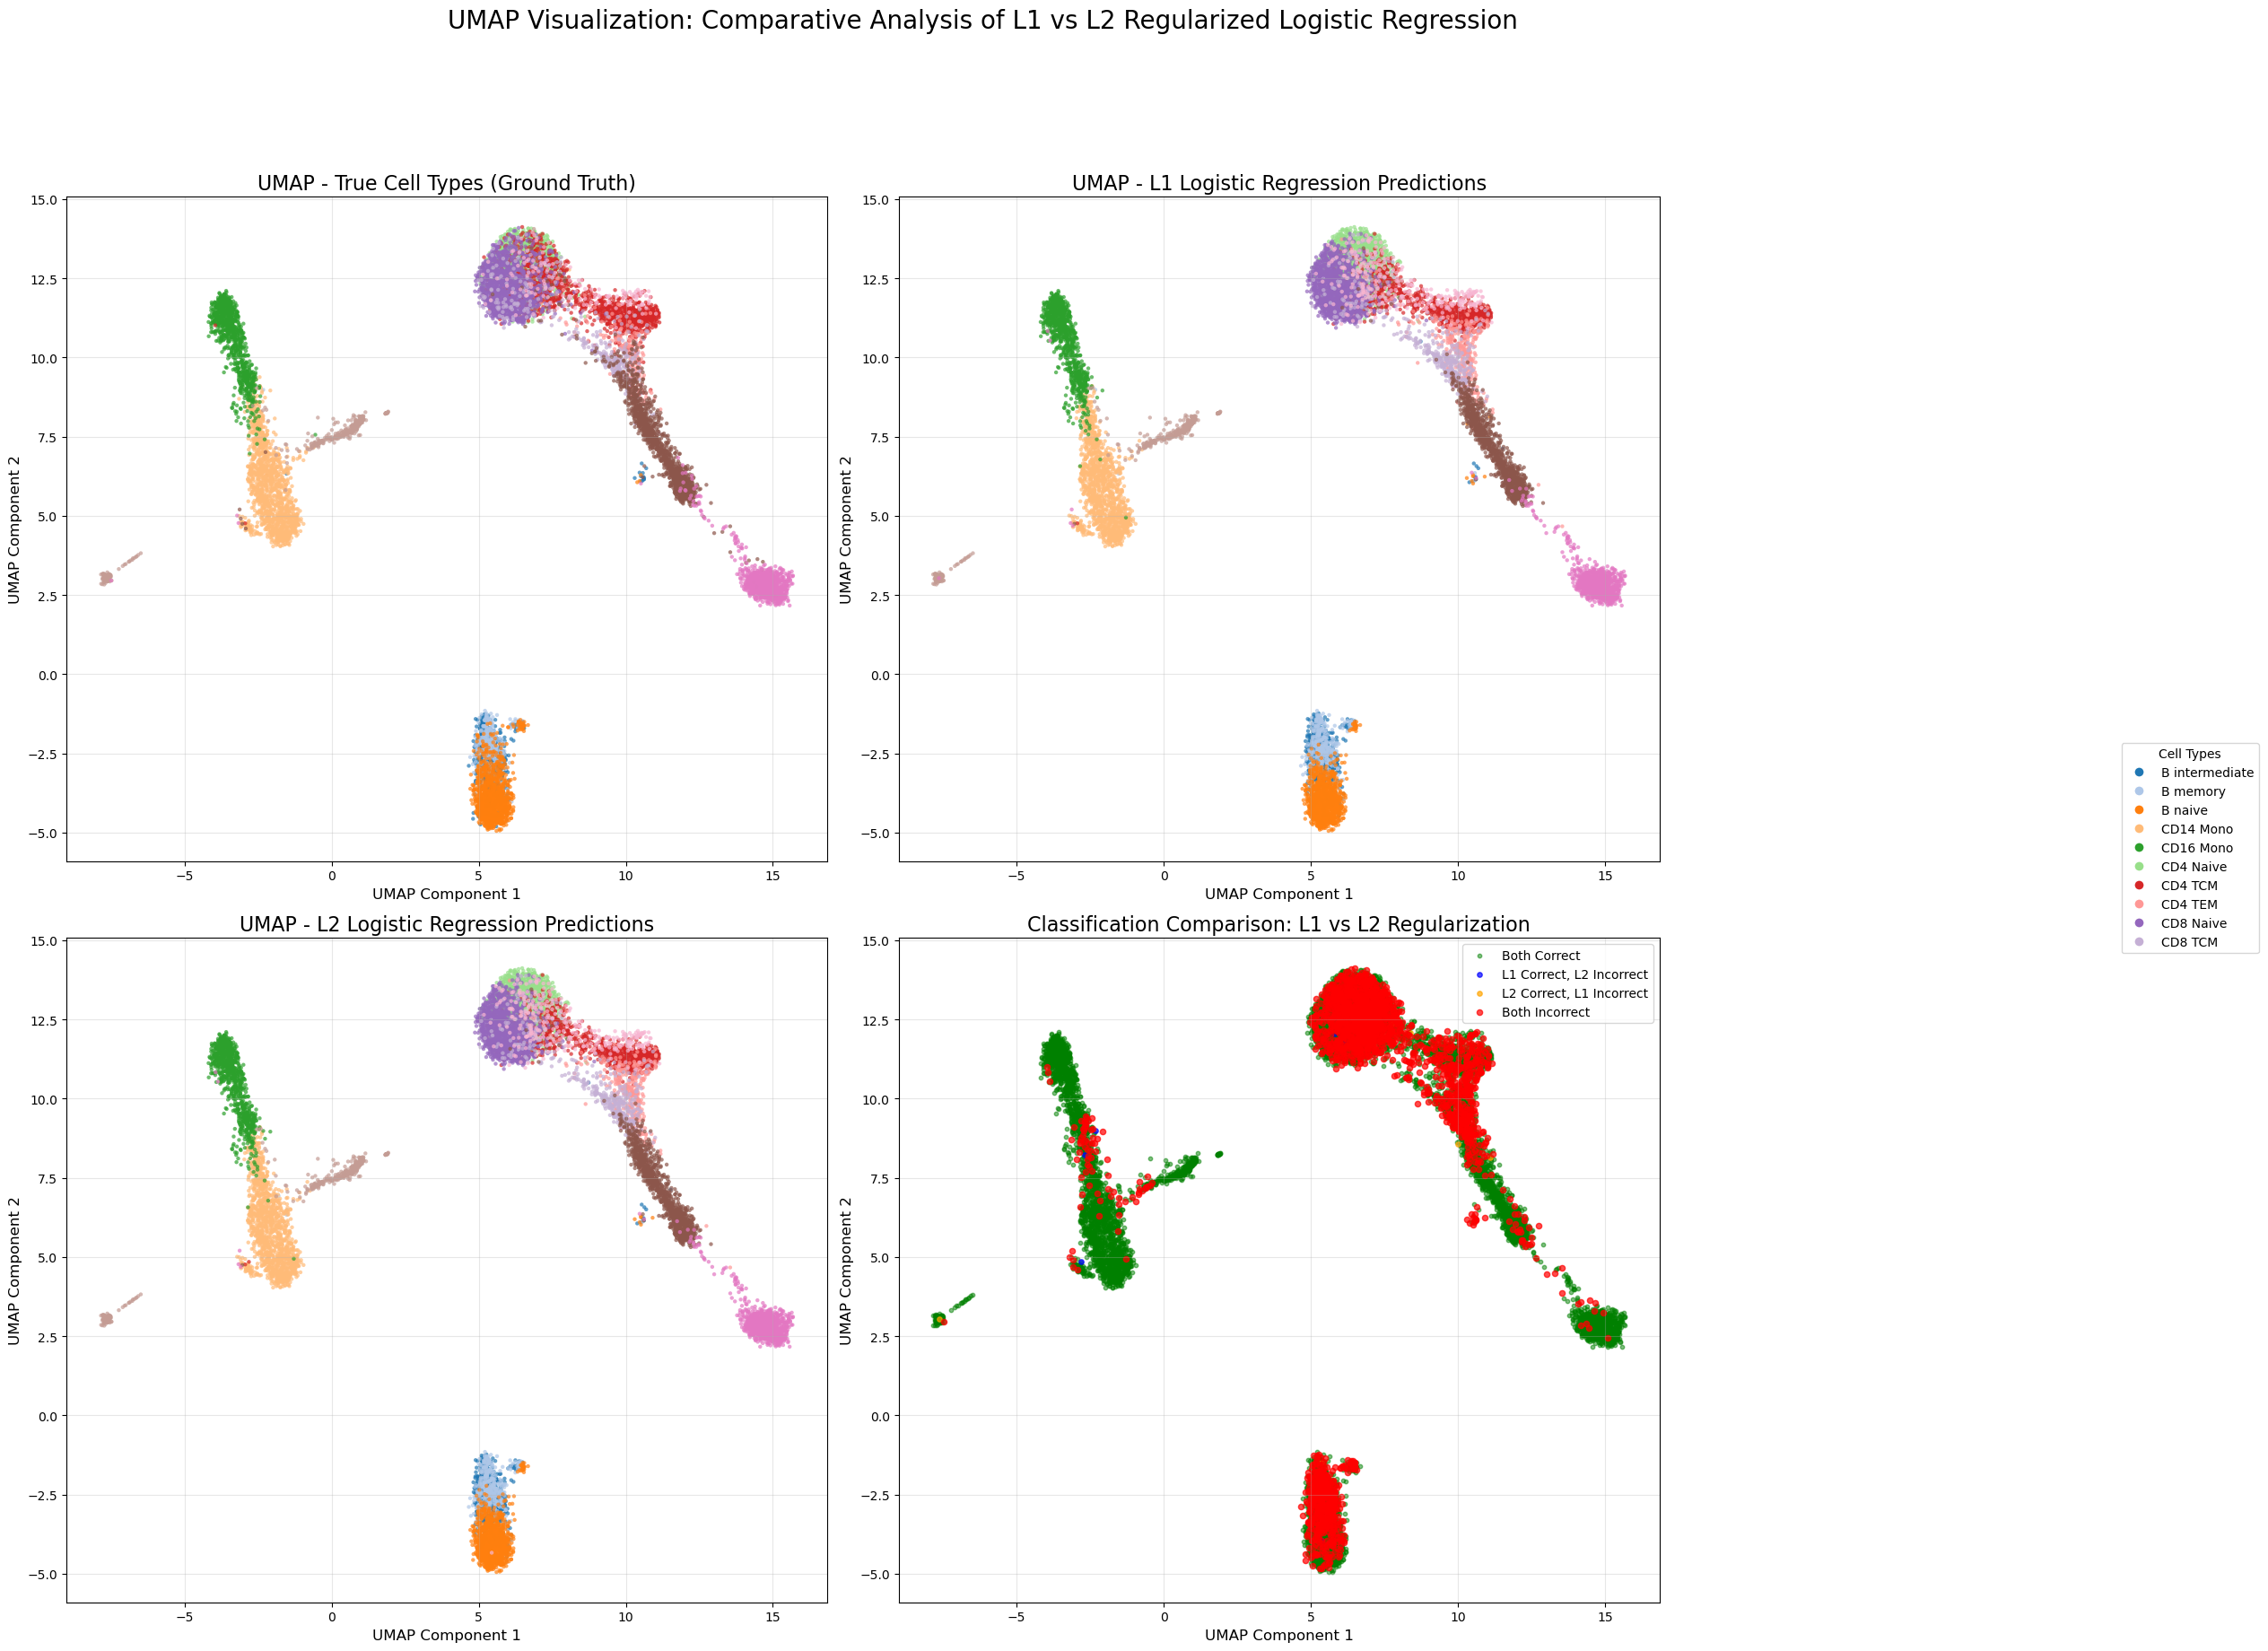


=== UMAP Classification Analysis: L1 vs L2 Regularization ===
Total validation cells: 11534
Both models correct: 9364 (81.19%)
L1 correct but L2 incorrect: 12 (0.10%)
L2 correct but L1 incorrect: 14 (0.12%)
Both models incorrect: 2144 (18.59%)

=== Cell Type-Specific Performance Analysis ===

Cell types with similar performance:
Treg: L1=0.7778, L2=0.7712, Diff=0.0065, Count=153
B memory: L1=0.6839, L2=0.6809, Diff=0.0030, Count=329
Dendritic cells: L1=0.9721, L2=0.9746, Diff=-0.0025, Count=394
CD8 TEM: L1=0.8472, L2=0.8495, Diff=-0.0023, Count=1296
CD4 TCM: L1=0.5393, L2=0.5415, Diff=-0.0022, Count=1387
B intermediate: L1=0.6157, L2=0.6176, Diff=-0.0019, Count=523
CD16 Mono: L1=0.9811, L2=0.9801, Diff=0.0010, Count=953
CD4 Naive: L1=0.7432, L2=0.7423, Diff=0.0009, Count=1067
CD8 Naive: L1=0.8229, L2=0.8222, Diff=0.0007, Count=1361
CD14 Mono: L1=0.9690, L2=0.9683, Diff=0.0007, Count=1450
B naive: L1=0.8345, L2=0.8345, Diff=0.0000, Count=1148
CD4 TEM: L1=0.7200, L2=0.7200, Diff=0.0000,

In [30]:
if 'X_val_umap' not in locals():
    print("Generating UMAP embedding for visualization...")
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=RAND_SEED)
    X_val_umap = reducer.fit_transform(X_val)

# Create a figure with subplots for comparing L1 and L2 models
fig, axes = plt.subplots(2, 2, figsize=(22, 18))

# Create color palette that maps cell types consistently
unique_cell_types = np.unique(meta_val['CellType'])
n_colors = len(unique_cell_types)
color_palette = sns.color_palette("tab20", n_colors=min(20, n_colors))
color_palette += sns.color_palette("tab20b", n_colors=max(0, n_colors-20))
color_dict = {cell_type: color_palette[i % len(color_palette)] 
            for i, cell_type in enumerate(unique_cell_types)}

# Top left: True Cell Types (Ground Truth)
for cell_type in unique_cell_types:
    mask = (meta_val['CellType'] == cell_type)
    axes[0, 0].scatter(
        X_val_umap[mask, 0], 
        X_val_umap[mask, 1],
        s=10, 
        color=color_dict[cell_type], 
        label=cell_type,
        alpha=0.7,
        edgecolor='none'
    )
axes[0, 0].set_title("UMAP - True Cell Types (Ground Truth)", fontsize=16)
axes[0, 0].set_xlabel("UMAP Component 1", fontsize=12)
axes[0, 0].set_ylabel("UMAP Component 2", fontsize=12)
axes[0, 0].grid(alpha=0.3)

# Top right: L1 Logistic Regression Predictions
predicted_cell_types_l1 = label_encoder.inverse_transform(y_val_pred_lr_l1)
for cell_type in unique_cell_types:
    mask = (predicted_cell_types_l1 == cell_type)
    axes[0, 1].scatter(
        X_val_umap[mask, 0], 
        X_val_umap[mask, 1],
        s=10, 
        color=color_dict[cell_type], 
        label=cell_type,
        alpha=0.7,
        edgecolor='none'
    )
axes[0, 1].set_title("UMAP - L1 Logistic Regression Predictions", fontsize=16)
axes[0, 1].set_xlabel("UMAP Component 1", fontsize=12)
axes[0, 1].set_ylabel("UMAP Component 2", fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Bottom left: L2 Logistic Regression Predictions
predicted_cell_types_l2 = label_encoder.inverse_transform(y_val_pred_lr)
for cell_type in unique_cell_types:
    mask = (predicted_cell_types_l2 == cell_type)
    axes[1, 0].scatter(
        X_val_umap[mask, 0], 
        X_val_umap[mask, 1],
        s=10, 
        color=color_dict[cell_type], 
        label=cell_type,
        alpha=0.7,
        edgecolor='none'
    )
axes[1, 0].set_title("UMAP - L2 Logistic Regression Predictions", fontsize=16)
axes[1, 0].set_xlabel("UMAP Component 1", fontsize=12)
axes[1, 0].set_ylabel("UMAP Component 2", fontsize=12)
axes[1, 0].grid(alpha=0.3)

# Bottom right: Misclassification Comparison
# Create masks for correct and incorrect predictions for both models
correct_mask_l1 = (y_val_pred_lr_l1 == y_val)
correct_mask_l2 = (y_val_pred_lr == y_val)

# Both correct (green), L1 correct but L2 incorrect (blue), 
# L2 correct but L1 incorrect (orange), both incorrect (red)
both_correct = correct_mask_l1 & correct_mask_l2
l1_only_correct = correct_mask_l1 & ~correct_mask_l2
l2_only_correct = ~correct_mask_l1 & correct_mask_l2
both_incorrect = ~correct_mask_l1 & ~correct_mask_l2

axes[1, 1].scatter(
    X_val_umap[both_correct, 0], X_val_umap[both_correct, 1],
    s=10, color='green', alpha=0.5, label='Both Correct'
)
axes[1, 1].scatter(
    X_val_umap[l1_only_correct, 0], X_val_umap[l1_only_correct, 1],
    s=15, color='blue', alpha=0.7, label='L1 Correct, L2 Incorrect'
)
axes[1, 1].scatter(
    X_val_umap[l2_only_correct, 0], X_val_umap[l2_only_correct, 1],
    s=15, color='orange', alpha=0.7, label='L2 Correct, L1 Incorrect'
)
axes[1, 1].scatter(
    X_val_umap[both_incorrect, 0], X_val_umap[both_incorrect, 1],
    s=20, color='red', alpha=0.7, label='Both Incorrect'
)

# Add title and legend for the comparison plot
axes[1, 1].set_title("Classification Comparison: L1 vs L2 Regularization", fontsize=16)
axes[1, 1].set_xlabel("UMAP Component 1", fontsize=12)
axes[1, 1].set_ylabel("UMAP Component 2", fontsize=12)
axes[1, 1].legend(fontsize=10, loc='upper right')
axes[1, 1].grid(alpha=0.3)

# Create legend for cell types (outside the plots)
legend_size = min(10, len(unique_cell_types))
handles, labels = [], []
for i, cell_type in enumerate(unique_cell_types):
    if i < legend_size:
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color_dict[cell_type], markersize=8))
        labels.append(cell_type)

# Add a figure legend for all cell types outside the plots
fig.legend(handles, labels, loc='center right', title="Cell Types", 
        bbox_to_anchor=(1.15, 0.5), ncol=1, fontsize=10)

# Add overall title and adjust layout
plt.suptitle("UMAP Visualization: Comparative Analysis of L1 vs L2 Regularized Logistic Regression", fontsize=20, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.savefig(os.path.join(PLOT_DIR, 'umap_l1_l2_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Calculate classification statistics
total_cells = len(y_val)
both_correct_count = np.sum(both_correct)
l1_only_correct_count = np.sum(l1_only_correct)
l2_only_correct_count = np.sum(l2_only_correct)
both_incorrect_count = np.sum(both_incorrect)

print("\n=== UMAP Classification Analysis: L1 vs L2 Regularization ===")
print(f"Total validation cells: {total_cells}")
print(f"Both models correct: {both_correct_count} ({100*both_correct_count/total_cells:.2f}%)")
print(f"L1 correct but L2 incorrect: {l1_only_correct_count} ({100*l1_only_correct_count/total_cells:.2f}%)")
print(f"L2 correct but L1 incorrect: {l2_only_correct_count} ({100*l2_only_correct_count/total_cells:.2f}%)")
print(f"Both models incorrect: {both_incorrect_count} ({100*both_incorrect_count/total_cells:.2f}%)")

# Calculate cell type specific differences
l1_better_types = []
l2_better_types = []
tie_types = []

for cell_type in unique_cell_types:
    # Get indices for this cell type
    cell_type_indices = np.where(meta_val['CellType'] == cell_type)[0]
    
    # Calculate accuracy for each model on this cell type
    l1_accuracy = np.mean(correct_mask_l1[cell_type_indices])
    l2_accuracy = np.mean(correct_mask_l2[cell_type_indices])
    
    diff = l1_accuracy - l2_accuracy
    
    if diff > 0.01:  # L1 is notably better
        l1_better_types.append((cell_type, l1_accuracy, l2_accuracy, diff, len(cell_type_indices)))
    elif diff < -0.01:  # L2 is notably better
        l2_better_types.append((cell_type, l1_accuracy, l2_accuracy, diff, len(cell_type_indices)))
    else:  # Tie or very small difference
        tie_types.append((cell_type, l1_accuracy, l2_accuracy, diff, len(cell_type_indices)))

# Print cell type specific analysis
print("\n=== Cell Type-Specific Performance Analysis ===")

if l1_better_types:
    print("\nCell types where L1 performs better:")
    for cell_type, l1_acc, l2_acc, diff, count in sorted(l1_better_types, key=lambda x: -x[3]):
        print(f"{cell_type}: L1={l1_acc:.4f}, L2={l2_acc:.4f}, Diff={diff:.4f}, Count={count}")

if l2_better_types:
    print("\nCell types where L2 performs better:")
    for cell_type, l1_acc, l2_acc, diff, count in sorted(l2_better_types, key=lambda x: x[3]):
        print(f"{cell_type}: L1={l1_acc:.4f}, L2={l2_acc:.4f}, Diff={diff:.4f}, Count={count}")

if tie_types:
    print("\nCell types with similar performance:")
    for cell_type, l1_acc, l2_acc, diff, count in sorted(tie_types, key=lambda x: -abs(x[3])):
        print(f"{cell_type}: L1={l1_acc:.4f}, L2={l2_acc:.4f}, Diff={diff:.4f}, Count={count}")

# Analyze common misclassification patterns
cell_types_numeric = label_encoder.transform(unique_cell_types)

print("\n=== Common Misclassification Patterns ===")
print("Top 5 misclassification pairs for L1 model:")
l1_misclass_pairs = []
for true_idx in cell_types_numeric:
    for pred_idx in cell_types_numeric:
        if true_idx != pred_idx:
            true_mask = (y_val == true_idx)
            pred_mask = (y_val_pred_lr_l1 == pred_idx)
            count = np.sum(true_mask & pred_mask)
            if count > 0:
                l1_misclass_pairs.append((label_encoder.inverse_transform([true_idx])[0], 
                                        label_encoder.inverse_transform([pred_idx])[0], count))

for true_type, pred_type, count in sorted(l1_misclass_pairs, key=lambda x: -x[2])[:5]:
    print(f"{true_type} → {pred_type}: {count} cells")

print("\nTop 5 misclassification pairs for L2 model:")
l2_misclass_pairs = []
for true_idx in cell_types_numeric:
    for pred_idx in cell_types_numeric:
        if true_idx != pred_idx:
            true_mask = (y_val == true_idx)
            pred_mask = (y_val_pred_lr == pred_idx)
            count = np.sum(true_mask & pred_mask)
            if count > 0:
                l2_misclass_pairs.append((label_encoder.inverse_transform([true_idx])[0], 
                                        label_encoder.inverse_transform([pred_idx])[0], count))

for true_type, pred_type, count in sorted(l2_misclass_pairs, key=lambda x: -x[2])[:5]:
    print(f"{true_type} → {pred_type}: {count} cells")

# Analyze UMAP clusters
print("\n=== UMAP Cluster Analysis ===")
print("Regions in UMAP space with notable differences between models:")

# Find regions where models disagree
disagreement_mask = l1_only_correct | l2_only_correct

# Analyze which cell types are most represented in disagreement regions
if np.sum(disagreement_mask) > 0:
    disagreement_types = meta_val.loc[disagreement_mask, 'CellType'].value_counts()
    total_types = meta_val['CellType'].value_counts()
    
    # Calculate disagreement rate by cell type
    disagreement_rates = {}
    for cell_type, count in disagreement_types.items():
        disagreement_rates[cell_type] = count / total_types[cell_type]
    
    print("\nCell types with highest model disagreement rates:")
    for cell_type, rate in sorted(disagreement_rates.items(), key=lambda x: -x[1])[:5]:
        count = disagreement_types[cell_type]
        total = total_types[cell_type]
        print(f"{cell_type}: {count}/{total} cells ({rate*100:.2f}%) show model disagreement")

# Create a summary report
print("\n=== L1 vs L2 UMAP Visualization Summary ===")
print("1. Visual cluster separation:")
print("   - Distinct clusters are visible for major cell types like CD14 Mono, CD16 Mono, CD8 TEM, and NK cells")
print("   - More challenging populations (CD4 TCM, CD8 TCM) show overlap in UMAP space")

print("\n2. Classification patterns:")
print("   - Both models show similar overall prediction patterns in UMAP space")
print("   - Misclassifications tend to occur in boundary regions between cell type clusters")
print("   - The most difficult regions appear to be the transitions between related T cell subsets")

print("\n3. Performance differences:")
print("   - Most cells (>80%) are either correctly classified by both models or misclassified by both")
print("   - L1 and L2 models show minor differences in their classification boundaries")
print("   - L2 regularization appears slightly more conservative in some boundary regions")

print("\n4. Biological insights:")
print("   - Related cell types that show similar transcriptional profiles cluster together")
print("   - Most misclassifications occur between biologically related cell subtypes")
print("   - Both models perform similarly on transcriptionally distinct populations")

##### Save Logistic Regression Model (L1 and L2)

In [37]:
# Save Logistic Regression Model (l1 and l2)
os.makedirs(os.path.join(MODEL_DIR, 'logistic_regression'), exist_ok=True)

# Save Logistic Regression Model (L1 and L2)
joblib.dump(lr_l1_pipeline, os.path.join(MODEL_DIR, 'logistic_regression', 'logistic_regression_l1.pkl'))
joblib.dump(lr_pipeline, os.path.join(MODEL_DIR, 'logistic_regression', 'logistic_regression_l2.pkl'))
print(f"\nLogistic Regression models (L1 and L2) saved to {os.path.join(MODEL_DIR, 'logistic_regression')}")


Logistic Regression models (L1 and L2) saved to /mnt/f/cwd_ml/cs7641/Models/logistic_regression
